In [1]:
!nvidia-smi

Sun Nov 13 17:21:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#@markdown <h3>← 输入了代码后运行以防止断开</h>


import IPython
from google.colab import output

display(IPython.display.Javascript('''
 function ClickConnect(){
   btn = document.querySelector("colab-connect-button")
   if (btn != null){
     console.log("Click colab-connect-button"); 
     btn.click() 
     }
   
   btn = document.getElementById('ok')
   if (btn != null){
     console.log("Click reconnect"); 
     btn.click() 
     }
  }
  
setInterval(ClickConnect,60000)
'''))

print("Done.")

<IPython.core.display.Javascript object>

Done.


In [100]:
import torch
import os
import copy
import random
import json
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import imageio
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.utils.fixes import linspace
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from torch.nn.utils import weight_norm
from torch import nn, optim
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display

import torch.nn.functional as F

!pip install optuna
import optuna
from optuna.trial import TrialState

from scipy.signal import hilbert, chirp

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

CLASS_NORMAL = 0
CLASS_ANOMALY = 1

class_names=['normal', 'anomaly']

id_to_class = {
  0.: "normal",
  1.: "anomaly",
}

class_to_id = {
  "normal": 0.,
  "anomaly": 1.,
}

sampling_frequency = 500

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

RANDOM_SEED = 2022
def seed_everything(seed: int):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)

seed_everything(RANDOM_SEED)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load data

In [4]:
class EarlyStopping:
  """Early stops the training if validation loss doesn't improve after a given patience."""
  def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
    """
    Args:
        patience (int): How long to wait after last time validation loss improved.
                        Default: 7
        verbose (bool): If True, prints a message for each validation loss improvement. 
                        Default: False
        delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                        Default: 0
        path (str): Path for the checkpoint to be saved to.
                        Default: 'checkpoint.pt'
        trace_func (function): trace print function.
                        Default: print            
    """
    self.patience = patience
    self.verbose = verbose
    self.counter = 0
    self.best_score = None
    self.early_stop = False
    self.val_loss_min = np.Inf
    self.delta = delta
    self.path = path
    self.trace_func = trace_func
  def __call__(self, val_loss, model):

    score = -val_loss

    if self.best_score is None:
      self.best_score = score
      self.save_checkpoint(val_loss, model)
    elif score < self.best_score + self.delta:
      self.counter += 1
      self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
      if self.counter >= self.patience:
          self.early_stop = True
    else:
      self.best_score = score
      self.save_checkpoint(val_loss, model)
      self.counter = 0

  def save_checkpoint(self, val_loss, model):
    '''Saves model when validation loss decrease.'''
    if self.verbose:
        self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
    torch.save(model.state_dict(), self.path)
    self.val_loss_min = val_loss

In [5]:
#load data from json files for selected milling run  
def openFile(path):
  with open(path) as file:
      data = json.load(file)
  file.close()
  return data

def getDataPayload(data):
  # Removes the header, footer, and the Block Events in the Payload and returns cleaned payload data into a np array
  payload_list = data['Payload']
  paydata = []
  for HFData in payload_list:
      if 'HFData' in HFData:
          tupel = HFData['HFData']
          for j in tupel:
              paydata.append(j)
  pdata = np.array(paydata)
  return pdata

def getSamplingRate(data):
  # Returns the sampling rate of the data
  sampling_rate = data['Header']['CycleTimeMs']
  return sampling_rate

def getSignalList(data):
  signal_list = []
  for index in range(0, len(data['Header']['SignalListHFData'])):
      signal_list.append((data['Header']['SignalListHFData'][index]['Name']) + ': ' + (
          data['Header']['SignalListHFData'][index]['Address']))
  return signal_list

def read_all_files():
  result=np.empty(0)
  path="drive/MyDrive/dataset/MA_NEW/"
  files=os.listdir(path) 
  count = 0
  for file in files:
    filepath=path+'/'+file
    if os.path.isfile(filepath): 
      print(file)  

      file = openFile(filepath)
      data= getDataPayload(file)
      if count == 0:
        result = data
        count+=1
      else:
        result = np.vstack((result, data))
  return result

def read_file(num_experiment, signal_name):
  if os.path.exists('drive/MyDrive/dataset/MA_NEW/Versuch'+str(num_experiment)+'_10mm_1'+'.json') == True: 			
    file1 = openFile('drive/MyDrive/dataset/MA_NEW/Versuch'+str(num_experiment)+'_10mm_1'+'.json')
    data1= getDataPayload(file1)
    data=data1

  if os.path.exists('drive/MyDrive/dataset/MA_NEW/Versuch'+str(num_experiment)+'_10mm_2'+'.json') == True:			
    file2 = openFile('drive/MyDrive/dataset/MA_NEW/Versuch'+str(num_experiment)+'_10mm_2'+'.json')
    data2= getDataPayload(file2)

    data = np.concatenate([data1, data2], axis=0) 
  if os.path.exists('drive/MyDrive/dataset/MA_NEW/Versuch'+str(num_experiment)+'_10mm_3'+'.json') == True:			
    file3 = openFile('drive/MyDrive/dataset/MA_NEW/Versuch'+str(num_experiment)+'_10mm_3'+'.json')
    data3= getDataPayload(file3)
    data = np.concatenate([data, data3], axis=0)
    
  #get sampling rate in milliseconds
  sampling_rate = getSamplingRate(file1)/1000                                   

  index=getSignalList(file1).index(signal_name)                                						 
  t = np.arange(0, (data[:, index].shape[0])*sampling_rate, sampling_rate) 
  df = pd.DataFrame({'time': t, 'values': data[:, index] }, columns=['time', 'values'])

  return df

In [6]:
signal_name = "Current: CURRENT|6"

df2 = read_file(2, signal_name) # 246510
df3 = read_file(3, signal_name) # 247102
df4 = read_file(4, signal_name) # 244316

In [7]:
df_dict = {'experiment2': df2,
    'experiment3': df3,
    'experiment4': df4}

start_2 = 13700
start_3 = start_2+300
start_4 = start_2-950

cicle_intervall_2 = 20000
cicle_intervall_3 = 20000
cicle_intervall_4 = 20000

pos_dict = {
  'experiment2':{
    0: start_2,
    1: start_2+cicle_intervall_2,
    2: start_2+cicle_intervall_2*2,
    3: start_2+cicle_intervall_2*3,
    4: start_2+cicle_intervall_2*4,
    5: start_2+cicle_intervall_2*5,
    6: start_2+cicle_intervall_2*6,
    7: start_2+cicle_intervall_2*7,
    8: start_2+cicle_intervall_2*8,
    9: start_2+cicle_intervall_2*9,
    10: start_2+cicle_intervall_2*10,
    11: start_2+cicle_intervall_2*11,},
  'experiment3':{
    0: start_3,
    1: start_3+cicle_intervall_3,
    2: start_3+cicle_intervall_3*2,
    3: start_3+cicle_intervall_3*3,
    4: start_3+cicle_intervall_3*4,
    5: start_3+cicle_intervall_3*5,
    6: start_3+cicle_intervall_3*6,
    7: start_3+cicle_intervall_3*7,
    8: start_3+cicle_intervall_3*8,
    9: start_3+cicle_intervall_3*9,
    10: start_3+cicle_intervall_3*10,
    11: start_3+cicle_intervall_3*11},
  'experiment4':{
    0: start_4,
    1: start_4+cicle_intervall_4,
    2: start_4+cicle_intervall_4*2,
    3: start_4+cicle_intervall_4*3,
    4: start_4+cicle_intervall_4*4,
    5: start_4+cicle_intervall_4*5,
    6: start_4+cicle_intervall_4*6,
    7: start_4+cicle_intervall_4*7,
    8: start_4+cicle_intervall_4*8,
    9: start_4+cicle_intervall_4*9,
    10: start_4+cicle_intervall_4*10,
    11: start_4+cicle_intervall_4*11},
}
half_intervall = 32 * 256
len_window = 256

class_to_id = {
  "normal": 0,
  "abnormal": 1,
}


In [51]:
def printData(df_name, signal_name, display_type, title, ax):
  cur = df_dict[df_name]
  if display_type == 'original':
    ax.plot(cur['time'].values[3800:-3800], cur['values'].values[3800:-3800], label = df_name, linewidth=0.5)
    ax.set_title(title)
  elif display_type == 'segmented':
    for j in pos_dict[df_name]:
      indexes = range(pos_dict[df_name][j] - half_intervall, pos_dict[df_name][j] + half_intervall)
      values = cur['values'][indexes]
      time_indexes = list(indexes)
      for index,value in enumerate(time_indexes):
        time_indexes[index] = time_indexes[index]/sampling_frequency

      if j == 0 or j == 1 or j == 2 or j == 5:
        ax.plot(time_indexes,
            values, 
            label = df_name,
            linewidth=0.5,
            color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
        # print(cur['values'][pos_dict[df_name][j] - half_intervall : pos_dict[df_name][j] + half_intervall])
      else:
        ax.plot(time_indexes,
            values, 
            label = df_name,
            linewidth=0.5,
            color=plt.rcParams['axes.prop_cycle'].by_key()['color'][3])
  elif display_type == 'normal':
    for j in pos_dict[df_name]:
      indexes = range(pos_dict[df_name][j] - half_intervall, pos_dict[df_name][j] + half_intervall)
      values = cur['values'][indexes]
      time_indexes = list(indexes)
      for index,value in enumerate(time_indexes):
        time_indexes[index] = time_indexes[index]/sampling_frequency

      if j == 0 or j == 1 or j == 2 or j == 5:
        ax.plot(time_indexes,
            values, 
            label = df_name,
            linewidth=0.5,
            color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
  elif display_type == 'anomaly':
    for j in pos_dict[df_name]:
      indexes = range(pos_dict[df_name][j] - half_intervall, pos_dict[df_name][j] + half_intervall)
      values = cur['values'][indexes]
      time_indexes = list(indexes)
      for index,value in enumerate(time_indexes):
        time_indexes[index] = time_indexes[index]/sampling_frequency
        
      if j != 0 and j != 1 and j != 2 and j != 5:
        ax.plot(time_indexes,
            values, 
            label = df_name,
            linewidth=0.5,
            color=plt.rcParams['axes.prop_cycle'].by_key()['color'][3])
  ax.set_title(title)

Text(0.5, 0, 'sample points')

Text(0, 0.5, 'current values (A)')

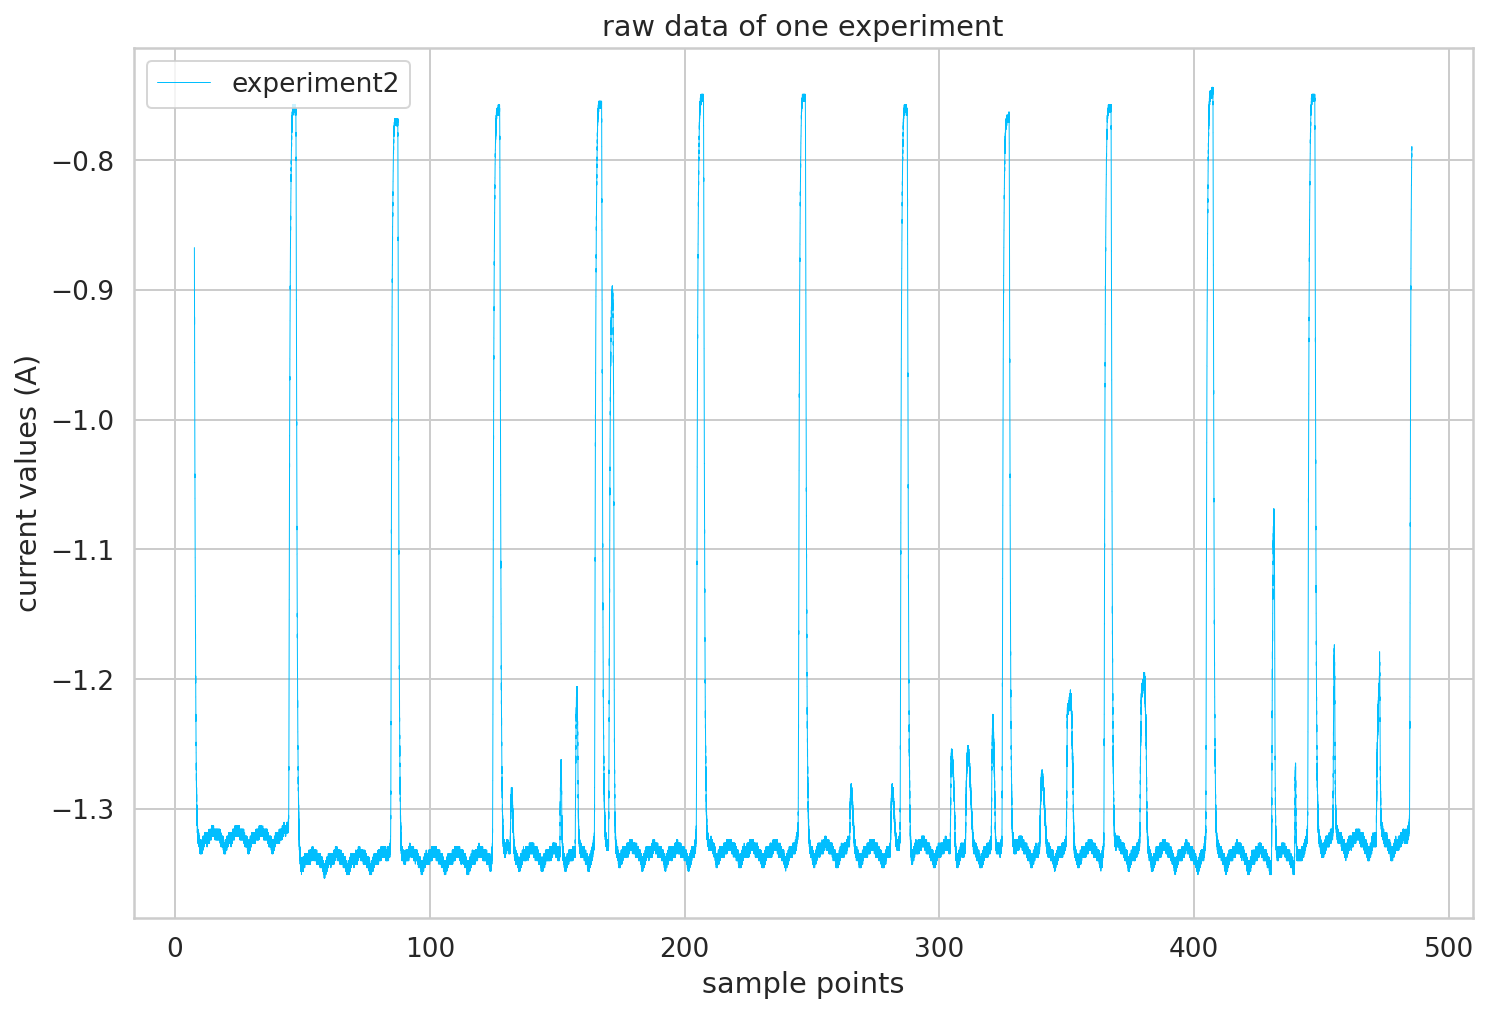

In [52]:
fig, ax = plt.subplots(figsize=(12,8))

printData(df_name='experiment2', signal_name=signal_name, display_type='original', title='raw data of one experiment', ax=ax)
# printData(df_name='experiment3', signal_name=signal_name, display_type='original', title='raw data of one experiment', ax=ax)
# printData(df_name='experiment4', signal_name=signal_name, display_type='original', title='raw data of one experiment', ax=ax)

plt.legend()
plt.xlabel('sample points')
plt.ylabel('current values (A)')
plt.show()


Text(0.5, 0, 'time steps (S)')

Text(0, 0.5, 'current values (A)')

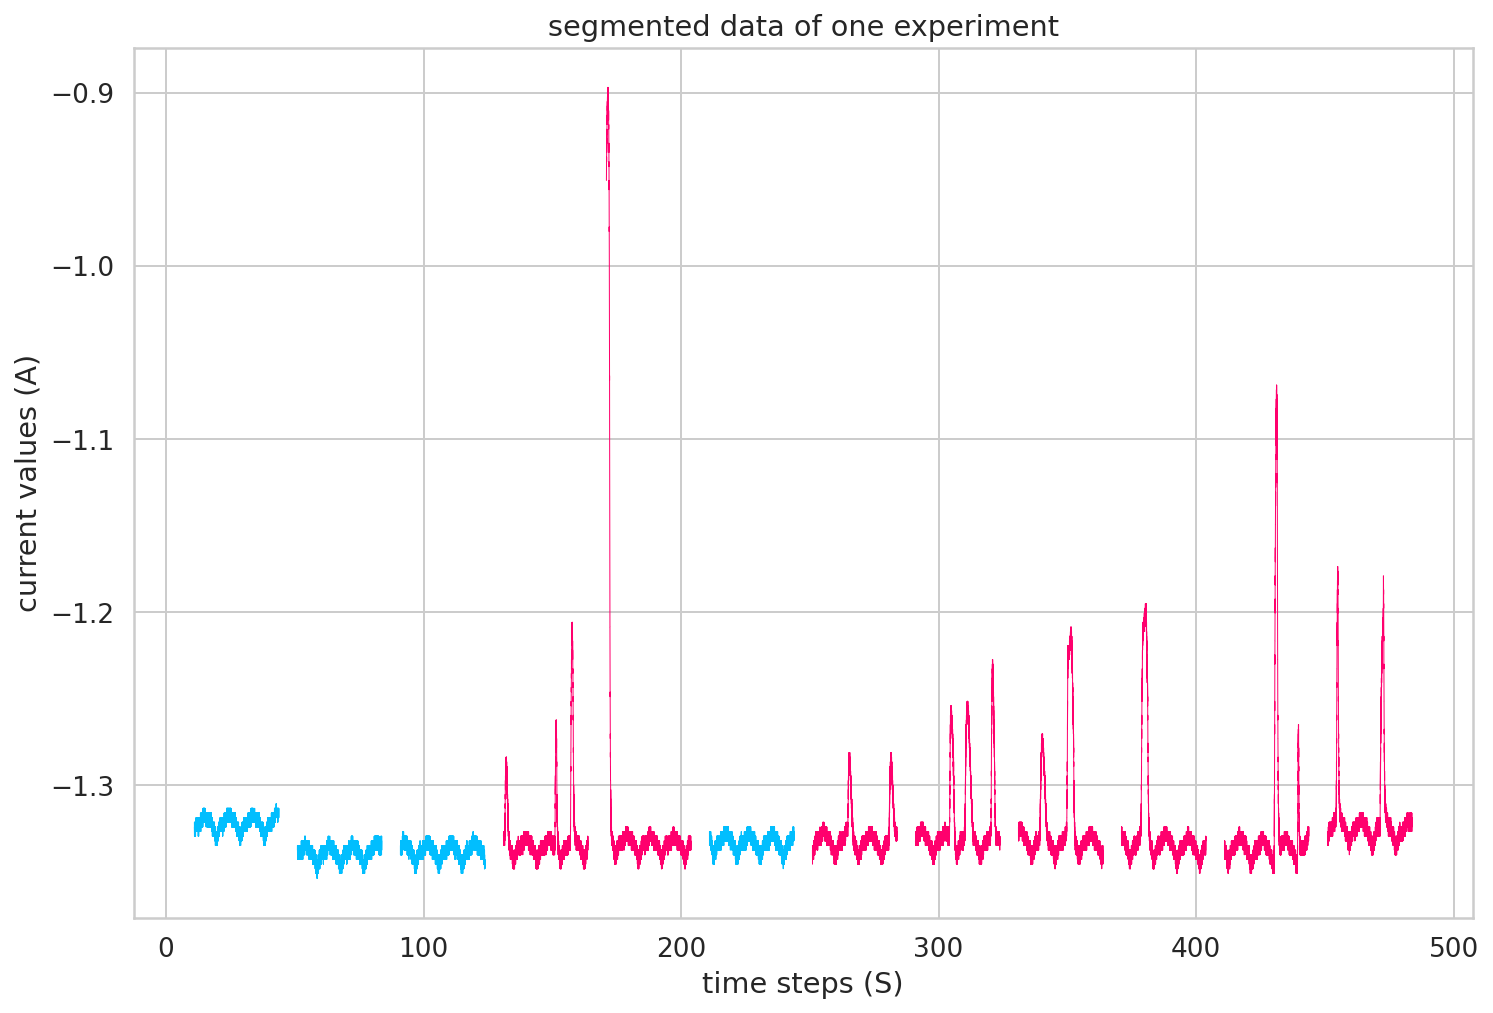

In [53]:
fig, ax = plt.subplots(figsize=(12,8))

printData(df_name='experiment2', signal_name=signal_name, display_type='segmented', title='segmented data of one experiment', ax=ax)
# printData(df_name='experiment3', signal_name=signal_name, display_type='segmented', title='segmented data of one experiment', ax=ax)
# printData(df_name='experiment4', signal_name=signal_name, display_type='segmented', title='segmented data of one experiment', ax=ax)

# plt.legend()
plt.xlabel('time steps (S)')
plt.ylabel('current values (A)')
plt.show()

Text(0.5, 0, 'time steps (S)')

Text(0, 0.5, 'current values (A)')

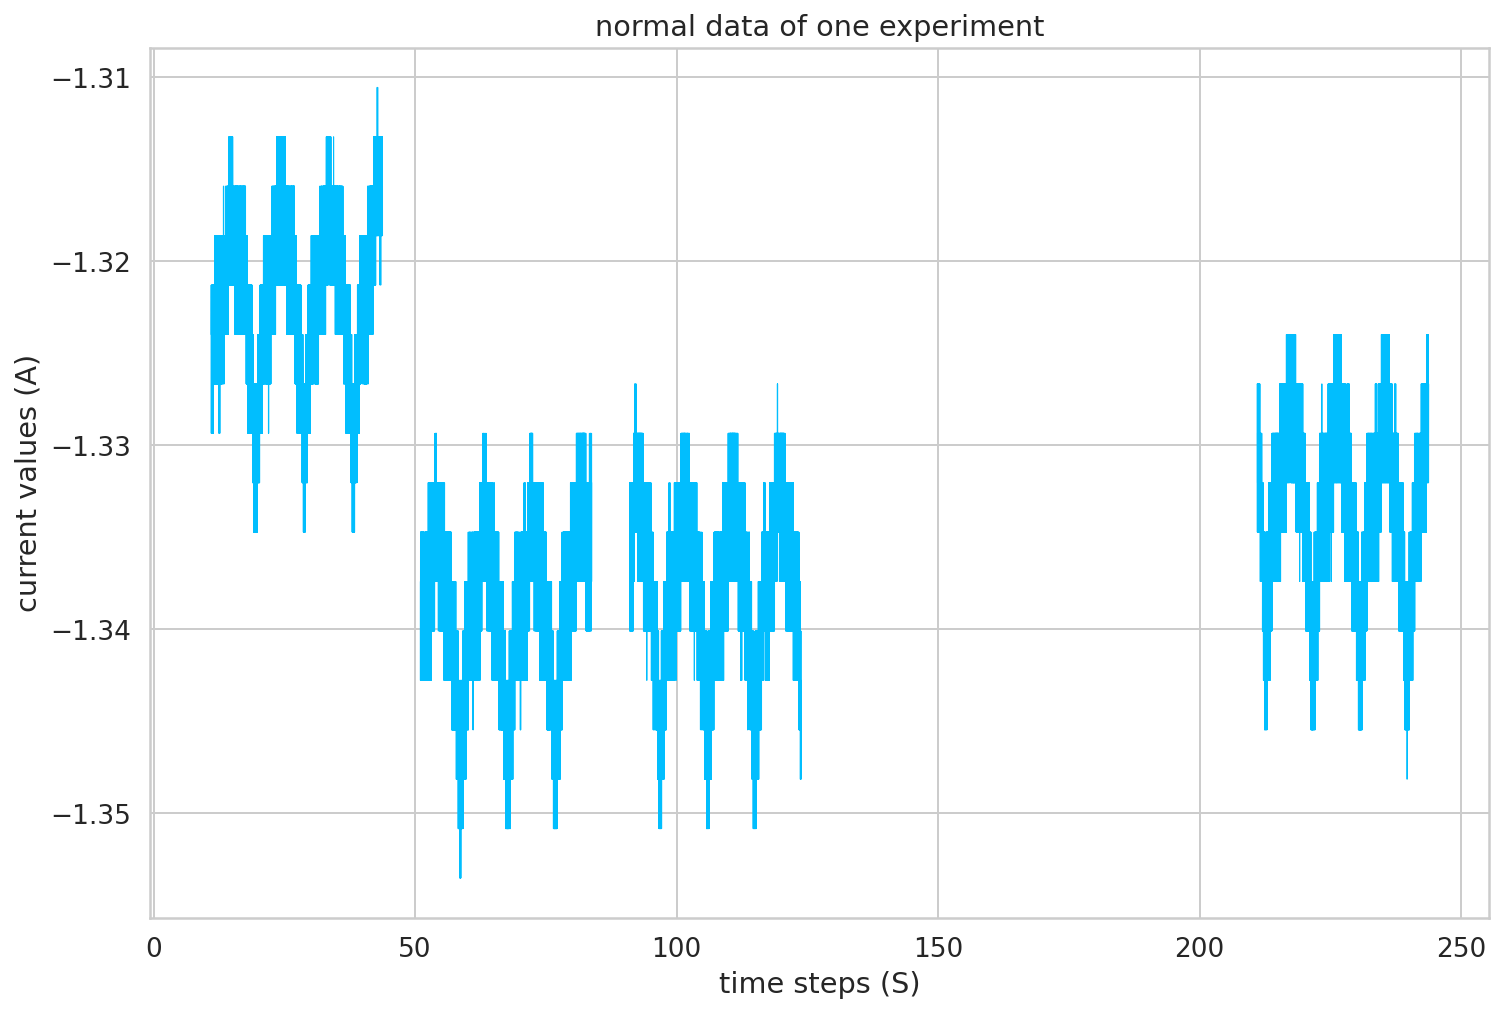

In [54]:
fig, ax = plt.subplots(figsize=(12,8))

printData(df_name='experiment2', signal_name=signal_name, display_type='normal', title='normal data of one experiment', ax=ax)
# printData(df_name='experiment3', signal_name=signal_name, display_type='normal', title='normal data of one experiment', ax=ax)
# printData(df_name='experiment4', signal_name=signal_name, display_type='normal', title='normal data of one experiment', ax=ax)

# plt.legend()
plt.xlabel('time steps (S)')
plt.ylabel('current values (A)')
plt.show()

Text(0.5, 0, 'time steps (S)')

Text(0, 0.5, 'current values (A)')

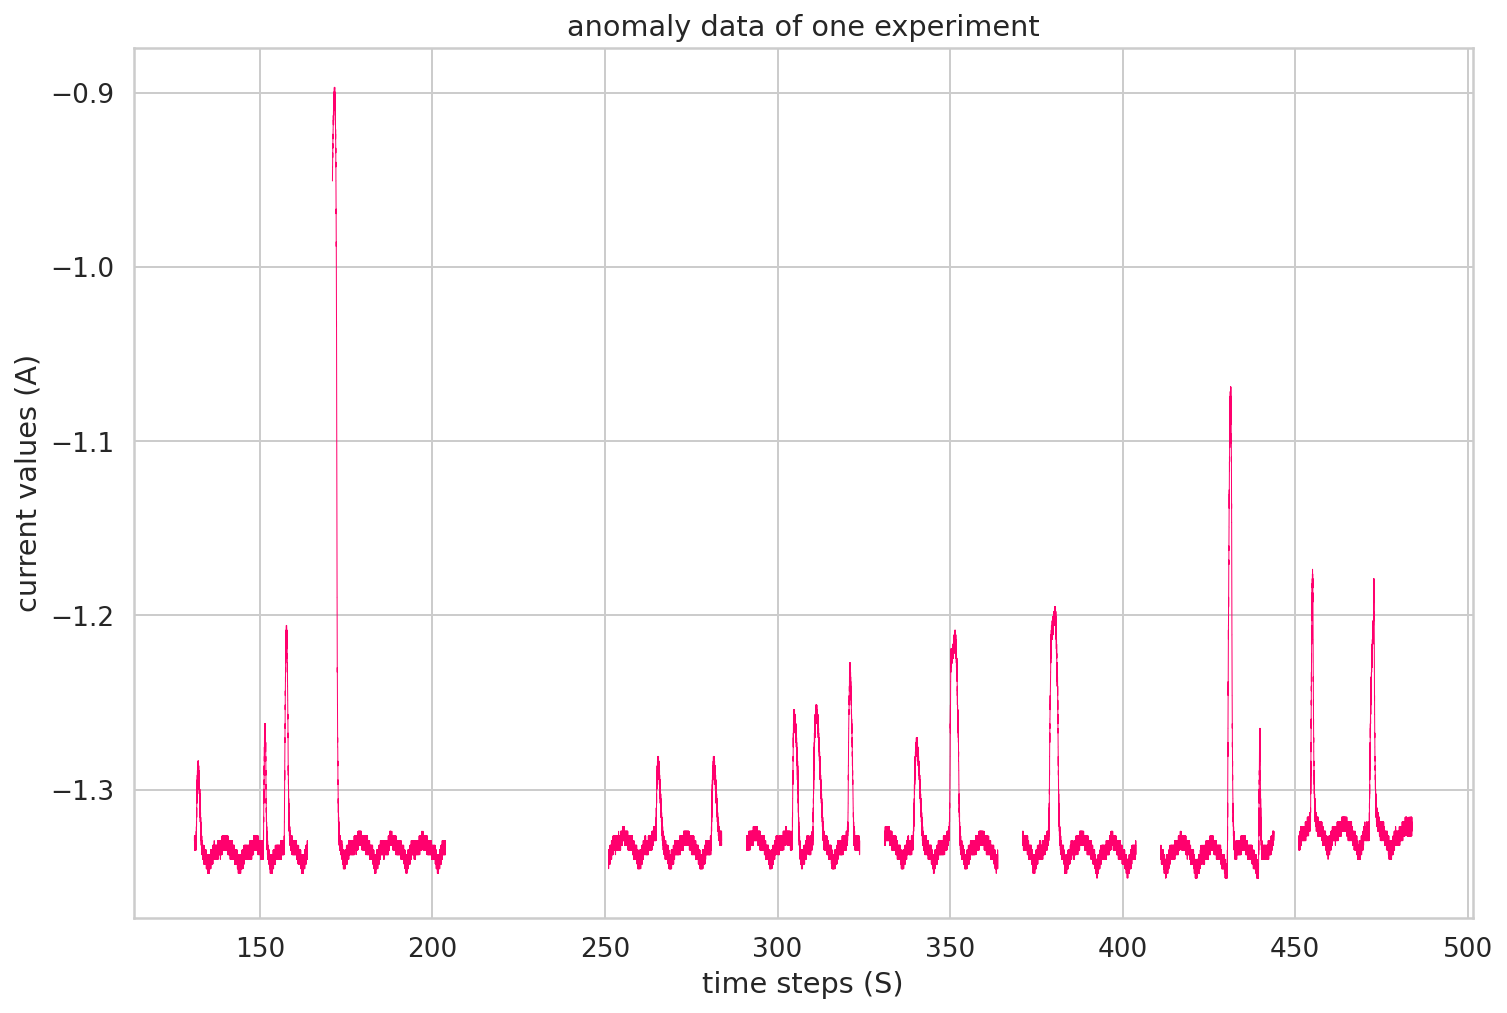

In [55]:
fig, ax = plt.subplots(figsize=(12,8))

printData(df_name='experiment2', signal_name=signal_name, display_type='anomaly', title='anomaly data of one experiment', ax=ax)
# printData(df_name='experiment3', signal_name=signal_name, display_type='anomaly', title='anomaly data of one experiment', ax=ax)
# printData(df_name='experiment4', signal_name=signal_name, display_type='anomaly', title='anomaly data of one experiment', ax=ax)

# plt.legend()
plt.xlabel('time steps (S)')
plt.ylabel('current values (A)')
plt.show()

(16384,)


Text(0.5, 1.0, 'normal data')

Text(0.5, 0, 'time steps (S)')

Text(0, 0.5, 'normalized current values (A)')

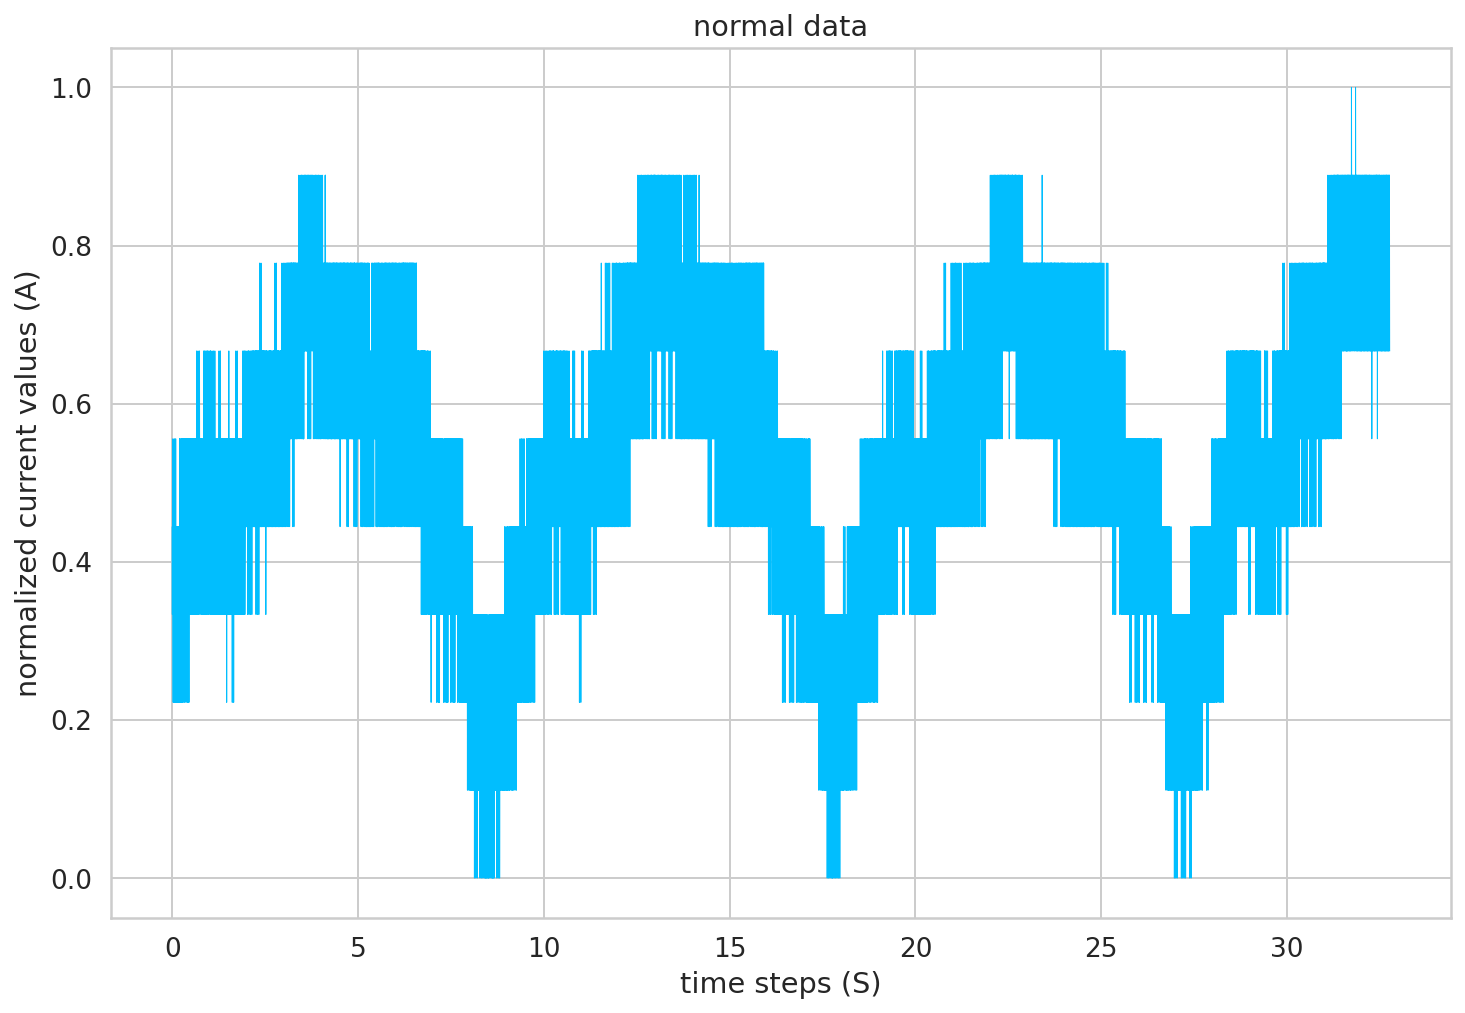

In [66]:
exp = 'experiment2'
id = 0

dff1 = df_dict[exp]['values'][pos_dict[exp][id] - half_intervall : pos_dict[exp][id] + half_intervall].values
dff1 = preprocessing.MinMaxScaler().fit_transform(dff1.reshape(-1, 1)).reshape(-1)

indexes = []
values = []
for index,value in enumerate(dff1):
  indexes.append(index/sampling_frequency)
  values.append(value)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(indexes, values, label = exp, linewidth=0.5, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
        
plt.title('normal data')
plt.xlabel('time steps (S)')
plt.ylabel('normalized current values (A)')
plt.show()

(256, 64)


Text(0.5, 1.0, 'normal data')

Text(0.5, 0, 'time steps (S)')

Text(0, 0.5, 'normalized current values (A)')

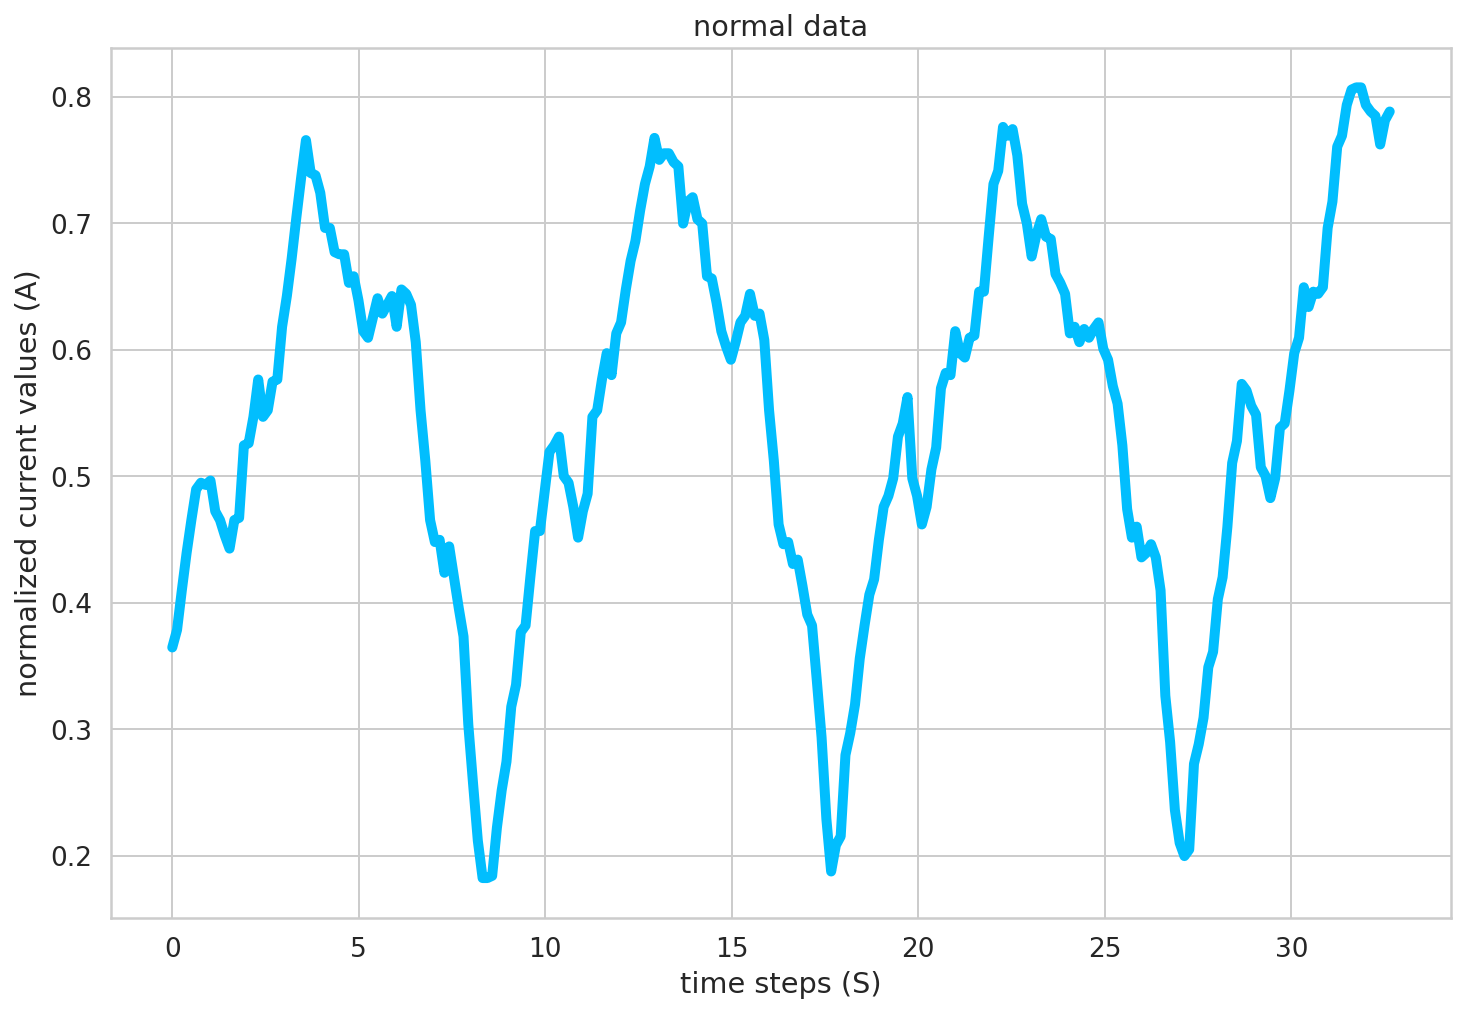

In [69]:
signal = dff1.reshape(-1, int(2*half_intervall/len_window))
print(signal.shape)

dowmsampled_signal = []
indexes = []

for index,value in enumerate(signal):
  indexes.append(index*64/sampling_frequency)
  dowmsampled_signal.append(value.mean())

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(indexes, dowmsampled_signal, label = exp, linewidth=5, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])

plt.title('normal data')
plt.xlabel('time steps (S)')
plt.ylabel('normalized current values (A)')
plt.show()

In [153]:
# id = 0

# for i in df_dict:
#   dff1 = df_dict[i]['values'][pos_dict[i][id] - half_intervall : pos_dict[i][id] + half_intervall].values
#   dff1 = preprocessing.MinMaxScaler().fit_transform(dff1.reshape(-1, 1)).reshape(-1)
#   plt.plot(dff1, label = i, linewidth=0.5)
  
# plt.title('normal data')
# plt.xlabel('time steps (S)')
# plt.ylabel('normalized current values (A)')
# plt.show()

In [154]:
# id = 0

# for i in df_dict:

#   dff1 = df_dict[i]['values'][pos_dict[i][id] - half_intervall : pos_dict[i][id] + half_intervall].values
#   dff1 = preprocessing.MinMaxScaler().fit_transform(dff1.reshape(-1, 1)).reshape(-1)
#   signal = dff1.reshape(-1, int(2*half_intervall/len_window))

#   b = []
#   for j in signal:
#     # b.append(j[0])
#     b.append(j.mean())
#   plt.plot(b, label = i)
# plt.title('normal data')
# plt.xlabel('time steps (S)')
# plt.ylabel('normalized current values (A)')
# plt.show()

In [ ]:
# exp = 'experiment2'

# for i in pos_dict[exp]:
#   if i == 0 or i == 1 or i == 2 or i == 5:
#     dff1 = df_dict[exp]['values'][pos_dict[exp][i] - half_intervall : pos_dict[exp][i] + half_intervall].values
#     # dff1 = preprocessing.MinMaxScaler().fit_transform(dff1.reshape(-1, 1)).reshape(-1)
#     signal = dff1.reshape(-1, int(2*half_intervall/len_window))

#     b = []
#     for j in signal:
#       # b.append(j[0])
#       b.append(j.mean())
#     plt.plot(b, label = i)
# plt.legend()
# plt.show()

In [ ]:
# # 对第一段进行fit 然后transform所有，结果上看并不太好

# exp = 'experiment2'
# id = 2

# dff1 = df_dict[exp]['values'][pos_dict[exp][id] - half_intervall : pos_dict[exp][id] + half_intervall].values

# scalar = preprocessing.MinMaxScaler().fit(df_dict[exp]['values'][pos_dict[exp][0] - half_intervall : pos_dict[exp][0] + half_intervall].values.reshape(-1, 1))
# dff1 = scalar.transform(dff1.reshape(-1, 1)).reshape(-1)

# # dff1 = preprocessing.MinMaxScaler().fit_transform(dff1.reshape(-1, 1)).reshape(-1)
# plt.plot(dff1, label = exp, linewidth=0.5)

# # signal = dff1
# # analytic_signal = hilbert(signal)
# # amplitude_envelope = np.abs(analytic_signal)

# # plt.plot(amplitude_envelope, linewidth=0.5)

In [ ]:
# signal = dff1.reshape(-1, int(2*half_intervall/len_window))
# # signal = dff1.reshape(-1, int(2*half_intervall/len_window))
# print(signal.shape)

# b = []
# for i in signal:
#   # b.append(i[0])
#   b.append(i.mean())
# plt.plot(b)

Text(0.5, 1.0, 'anomaly data')

Text(0.5, 0, 'time steps (S)')

Text(0, 0.5, 'normalized current values (A)')

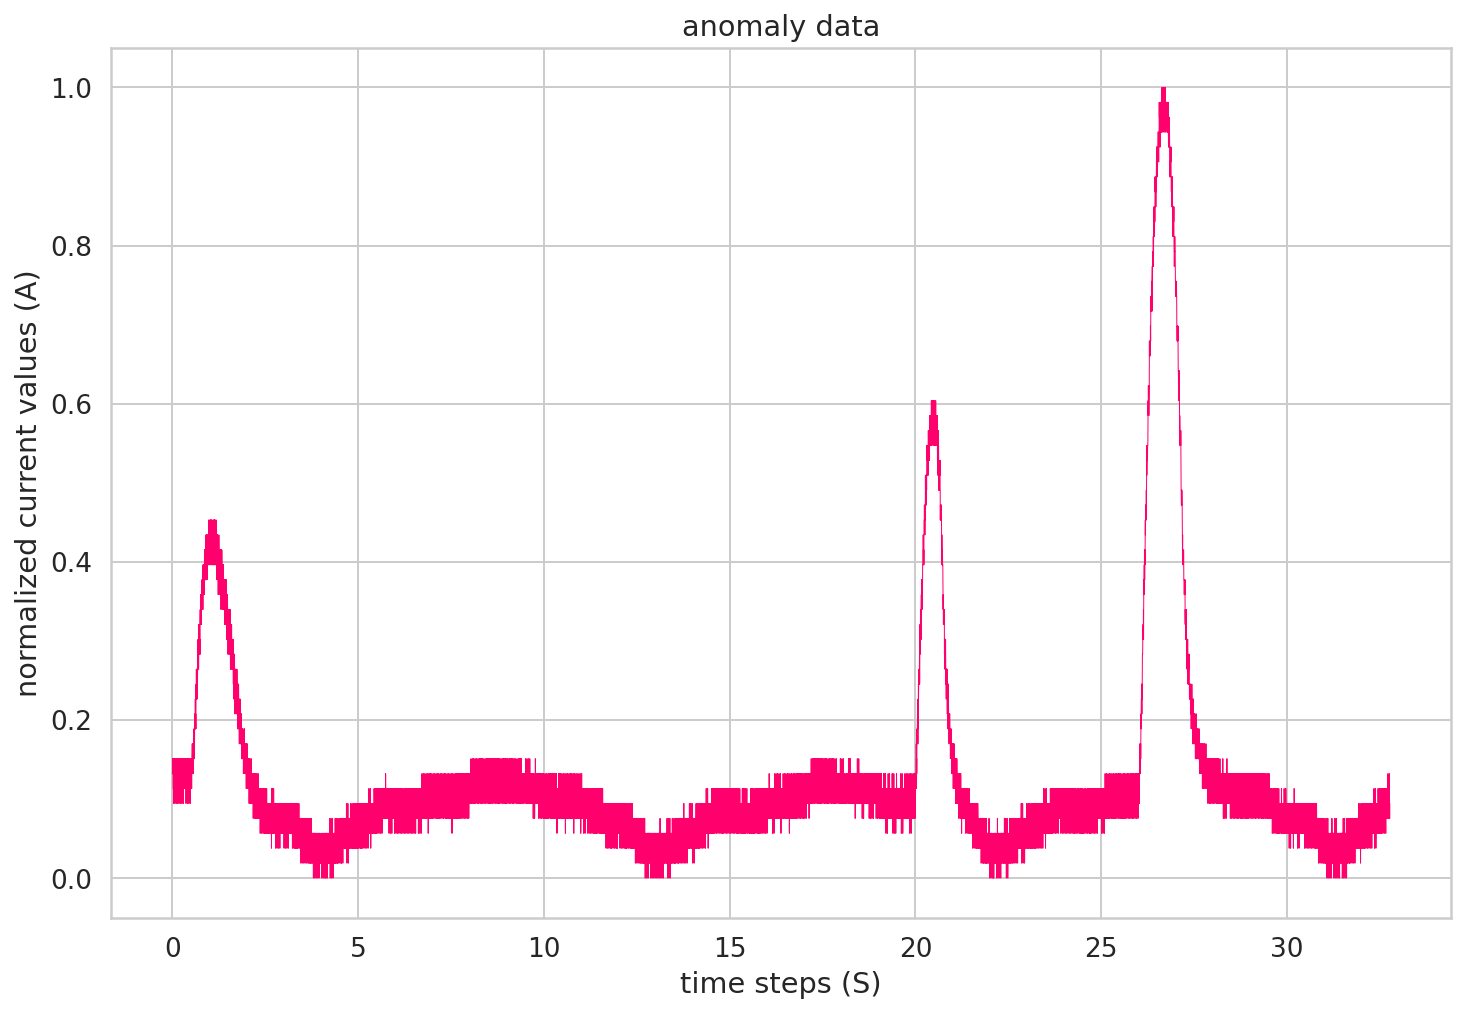

In [71]:
exp = 'experiment2'
id = 3

dff1 = df_dict[exp]['values'][pos_dict[exp][id] - half_intervall : pos_dict[exp][id] + half_intervall].values
dff1 = preprocessing.MinMaxScaler().fit_transform(dff1.reshape(-1, 1)).reshape(-1)

indexes = []
values = []
for index,value in enumerate(dff1):
  indexes.append(index/sampling_frequency)
  values.append(value)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(indexes, values, label = exp, linewidth=0.5, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][3])

plt.title('anomaly data')
plt.xlabel('time steps (S)')
plt.ylabel('normalized current values (A)')
plt.show()

Text(0.5, 1.0, 'anomaly data')

Text(0.5, 0, 'time steps (S)')

Text(0, 0.5, 'normalized current values (A)')

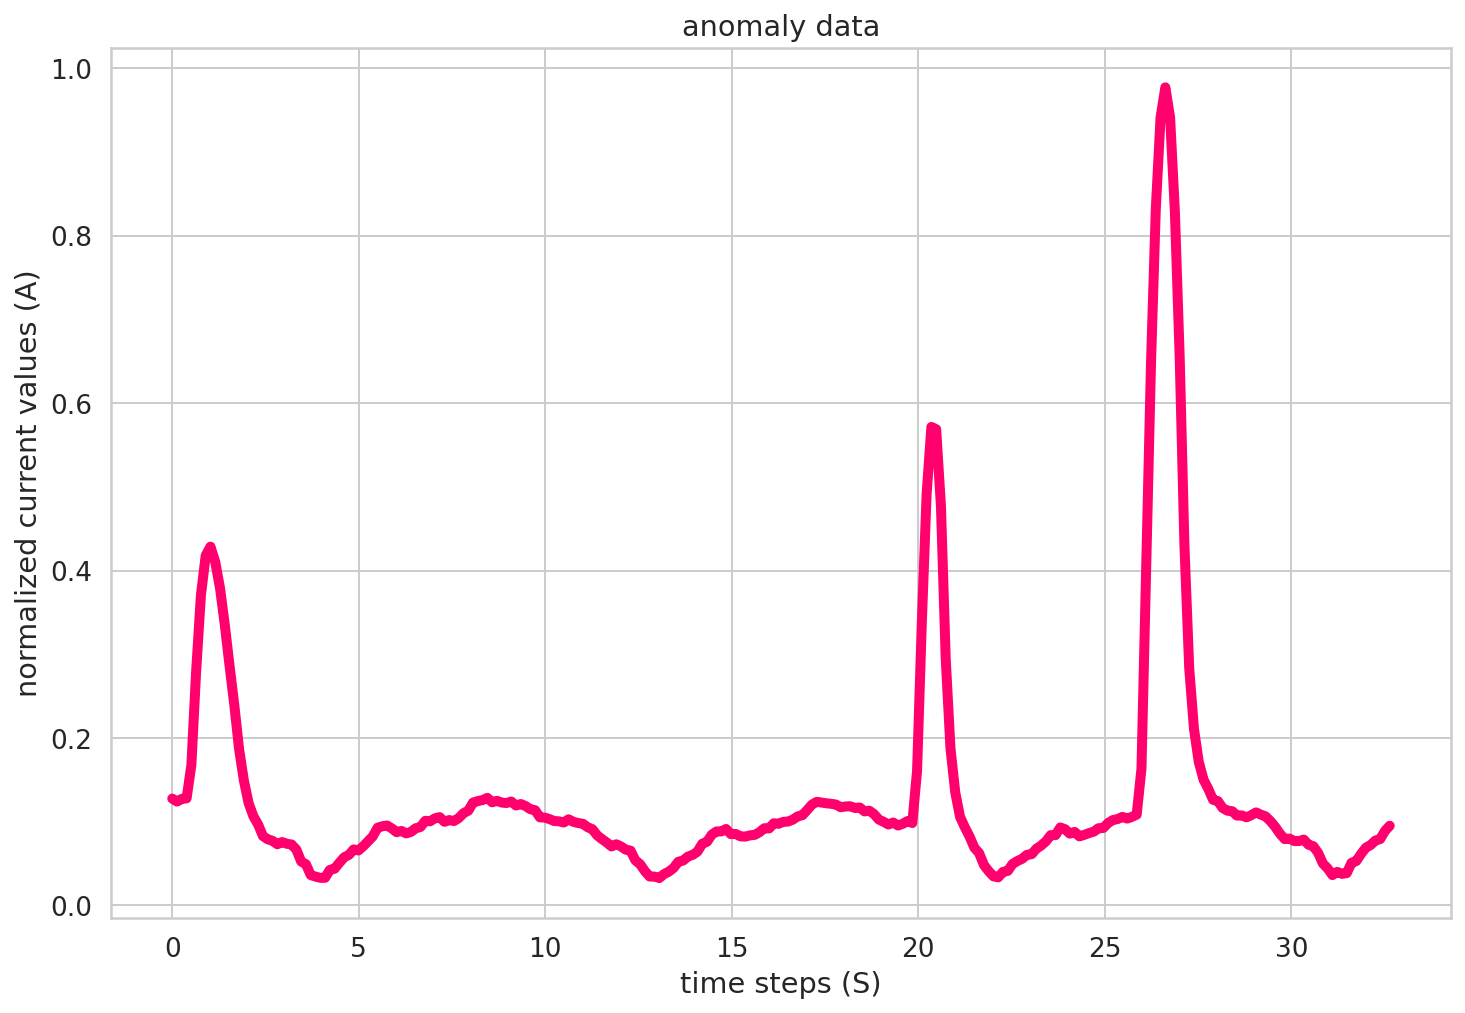

In [72]:
signal = dff1.reshape(-1, int(2*half_intervall/len_window))

dowmsampled_signal = []
indexes = []

for index,value in enumerate(signal):
  indexes.append(index*64/sampling_frequency)
  dowmsampled_signal.append(value.mean())

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(indexes, dowmsampled_signal, label = exp, linewidth=5, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][3])

plt.title('anomaly data')
plt.xlabel('time steps (S)')
plt.ylabel('normalized current values (A)')
plt.show()


In [73]:
# id = 3

# for i in df_dict:

#   dff1 = df_dict[i]['values'][pos_dict[i][id] - half_intervall : pos_dict[i][id] + half_intervall].values
#   # dff1 = preprocessing.MinMaxScaler().fit_transform(dff1.reshape(-1, 1)).reshape(-1)
#   plt.plot(dff1, label = i, linewidth=0.5)
# plt.legend()
# plt.title('anomaly data')
# plt.xlabel('time step')
# plt.ylabel('amplitude')
# plt.show()

In [74]:
# id = 3

# for i in df_dict:

#   dff1 = df_dict[i]['values'][pos_dict[i][id] - half_intervall : pos_dict[i][id] + half_intervall].values
#   dff1 = preprocessing.MinMaxScaler().fit_transform(dff1.reshape(-1, 1)).reshape(-1)
#   signal = dff1.reshape(-1, int(2*half_intervall/len_window))

#   b = []
#   for j in signal:
#     # b.append(j[0])
#     b.append(j.mean())
#   plt.plot(b, label = i)
# plt.legend()
# plt.title('anomaly data')
# plt.xlabel('time step')
# plt.ylabel('amplitude')
# plt.show()

In [75]:
# write circle into csv

real_circle_path  = "drive/MyDrive/dataset/MA_NEW/circle_data.csv"

def write_circle2csv(path, preprocess):
  result_df = pd.DataFrame()
  for i in pos_dict:
    for j in pos_dict[i]:
      cur = df_dict[i]['values'][pos_dict[i][j] - half_intervall : pos_dict[i][j] + half_intervall].values
      if preprocess == True:
        cur = preprocessing.MinMaxScaler().fit_transform(cur.reshape(-1, 1)).reshape(-1)
      cur = cur.reshape(-1, int(2*half_intervall/len_window))
      tmp = []
      for curr in cur:
        # tmp.append(curr[0])
        tmp.append(curr.mean())
      if j == 0 or j == 1 or j == 2 or j == 5:
        result_df = result_df.append(pd.DataFrame(np.append(tmp, class_to_id['normal'])).T, ignore_index=True)
      else:
        result_df = result_df.append(pd.DataFrame(np.append(tmp, class_to_id['abnormal'])).T, ignore_index=True)

  result_df.to_csv(path, index=False, header=False, mode='w+')

In [76]:
# write_circle2csv(real_circle_path, preprocess = True)

In [101]:
real_circle_df = pd.read_csv(real_circle_path, header=None)
real_circle_df.rename(columns={256: 'target'}, inplace=True)
real_circle_df

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,target
0,0.364585,0.378472,0.409723,0.439237,0.465280,0.489586,0.494794,0.493057,0.496530,0.472224,...,0.805564,0.807301,0.807301,0.793410,0.788201,0.784729,0.762155,0.781255,0.788201,0.0
1,0.607658,0.640643,0.605922,0.605924,0.609394,0.579881,0.604187,0.598977,0.616339,0.637170,...,0.774322,0.763904,0.743071,0.762168,0.763903,0.777793,0.796892,0.793418,0.802100,0.0
2,0.631942,0.628469,0.645829,0.623262,0.647565,0.685761,0.734370,0.791659,0.793394,0.802076,...,0.517360,0.517361,0.539930,0.513887,0.520834,0.472223,0.442711,0.402778,0.326390,0.0
3,0.127656,0.124119,0.127361,0.127951,0.167750,0.279780,0.370581,0.418047,0.428661,0.410381,...,0.051007,0.053070,0.061620,0.068990,0.072233,0.077539,0.079308,0.089036,0.095228,1.0
4,0.907646,0.944569,0.969495,0.985585,0.992653,0.987631,0.967170,0.917411,0.819011,0.621095,...,0.028368,0.031530,0.031809,0.034320,0.034878,0.034227,0.034506,0.033297,0.034692,1.0
5,0.781266,0.743070,0.727445,0.699669,0.675363,0.612867,0.585089,0.560786,0.479186,0.439257,...,0.718767,0.739597,0.736128,0.743071,0.755222,0.763905,0.800363,0.840292,0.875014,0.0
6,0.108076,0.113934,0.119143,0.136069,0.146485,0.156902,0.166668,0.175783,0.194011,0.197267,...,0.421873,0.367836,0.335936,0.307291,0.294920,0.296874,0.281900,0.285156,0.276041,1.0
7,0.124290,0.126776,0.122159,0.127486,0.132812,0.134588,0.143111,0.141335,0.143111,0.147727,...,0.125710,0.127131,0.126775,0.132457,0.132457,0.129261,0.127485,0.119673,0.113991,1.0
8,0.151745,0.155951,0.163463,0.165266,0.167971,0.165567,0.162862,0.162862,0.157454,0.159857,...,0.078729,0.074523,0.065809,0.054091,0.049583,0.045677,0.050785,0.054692,0.061603,1.0
9,0.146281,0.137661,0.136044,0.133081,0.130117,0.132003,0.130656,0.129309,0.131195,0.129040,...,0.091325,0.094289,0.099946,0.101832,0.102640,0.103448,0.099677,0.102909,0.105872,1.0


In [78]:
# # write window into csv

# real_window_path  = "drive/MyDrive/dataset/MA_NEW/window_data.csv"

# def write_window2csv(path, preprocess):
#   result_df = pd.DataFrame()
#   for i in pos_dict:
#     for j in pos_dict[i]:
#       cur = df_dict[i]['values'][pos_dict[i][j] - half_intervall : pos_dict[i][j] + half_intervall].values
#       if preprocess == True:
#         cur = preprocessing.MinMaxScaler().fit_transform(cur.reshape(-1, 1)).reshape(-1)
#       k = 0
#       while k*len_window != len(cur):
#         tmp = cur[k*len_window : (k+1)*len_window]
#         if j == 0 or j == 1 or j == 2 or j == 5:
#           result_df = result_df.append(pd.DataFrame(np.append(tmp, class_to_id['normal'])).T, ignore_index=True)
#         else:
#           result_df = result_df.append(pd.DataFrame(np.append(tmp, class_to_id['abnormal'])).T, ignore_index=True)
#         k+=1     
#   result_df.to_csv(path, index=False, header=False, mode='w+')  

In [79]:
# write_window2csv(real_window_path, preprocess = True)

In [80]:
# real_window_df = pd.read_csv(real_window_path, header=None)
# real_window_df.rename(columns={256: 'target'}, inplace=True)
# real_window_df

In [102]:
# choose which data to use

real_df = real_circle_df
# real_df = real_window_df

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'normal'), Text(0, 0, 'anomaly')]

Text(-0.050000000000000044, 12.05, '12.0')

Text(0.95, 24.05, '24.0')

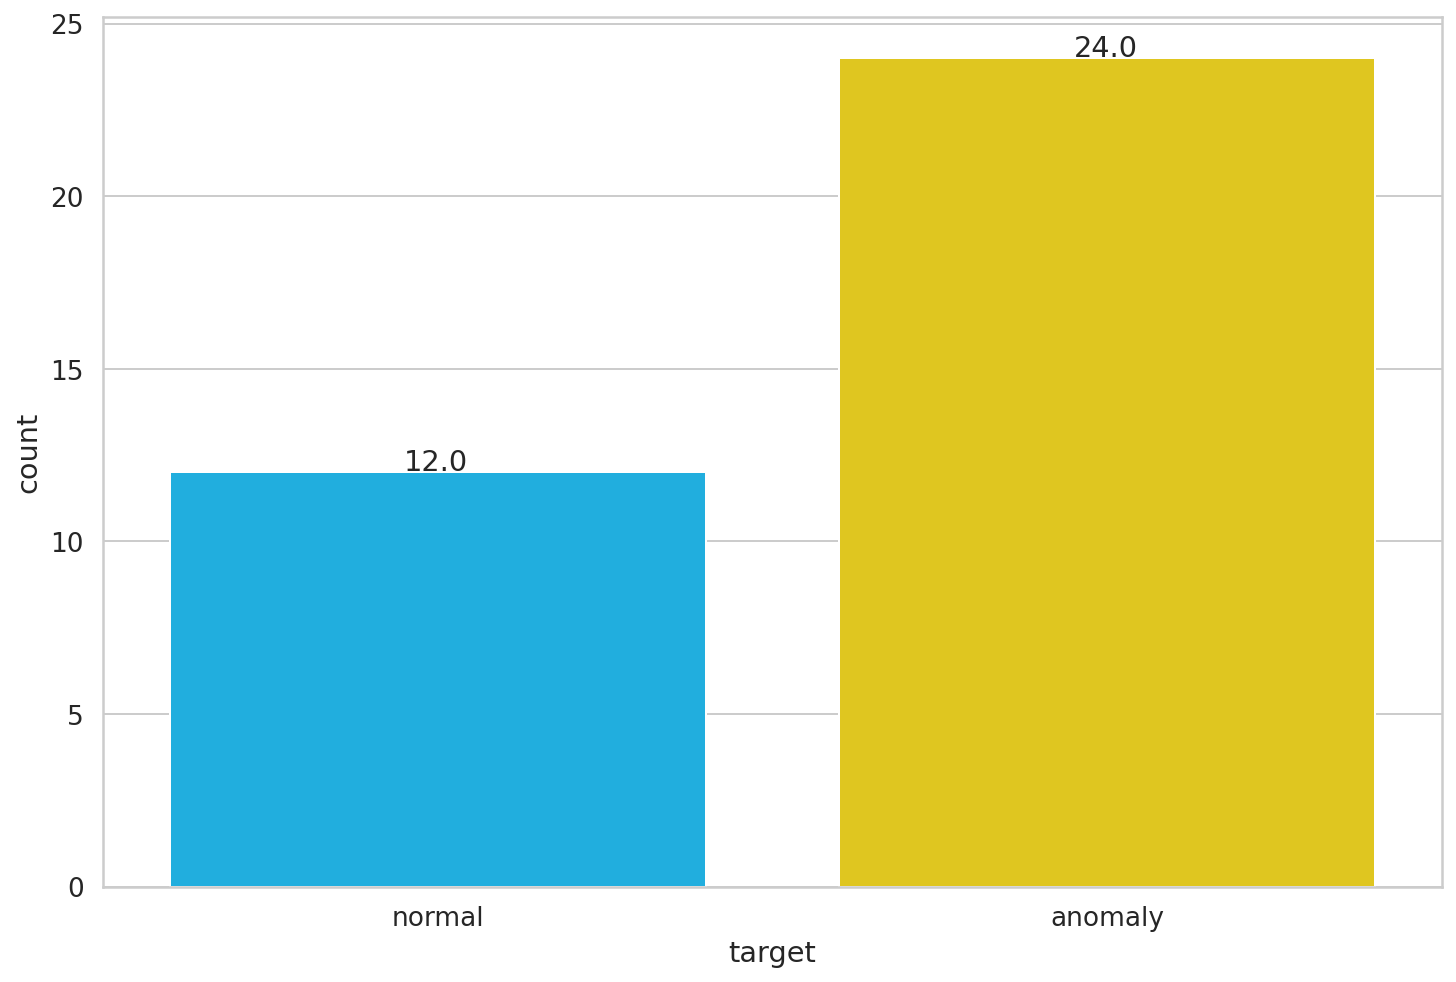

In [103]:
ax = sns.countplot(real_df.target)
ax.set_xticklabels(class_names)
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+0.05))

plt.show()

In [104]:
normal_df = real_df[real_df.target==class_to_id['normal']].drop(labels='target', axis=1)
normal_df

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.364585,0.378472,0.409723,0.439237,0.465280,0.489586,0.494794,0.493057,0.496530,0.472224,...,0.793410,0.805564,0.807301,0.807301,0.793410,0.788201,0.784729,0.762155,0.781255,0.788201
1,0.607658,0.640643,0.605922,0.605924,0.609394,0.579881,0.604187,0.598977,0.616339,0.637170,...,0.795155,0.774322,0.763904,0.743071,0.762168,0.763903,0.777793,0.796892,0.793418,0.802100
2,0.631942,0.628469,0.645829,0.623262,0.647565,0.685761,0.734370,0.791659,0.793394,0.802076,...,0.527778,0.517360,0.517361,0.539930,0.513887,0.520834,0.472223,0.442711,0.402778,0.326390
5,0.781266,0.743070,0.727445,0.699669,0.675363,0.612867,0.585089,0.560786,0.479186,0.439257,...,0.717028,0.718767,0.739597,0.736128,0.743071,0.755222,0.763905,0.800363,0.840292,0.875014
12,0.579680,0.578115,0.576552,0.578117,0.553116,0.579680,0.592178,0.617176,0.659363,0.649989,...,0.639050,0.651551,0.643738,0.684365,0.679677,0.678115,0.678115,0.653115,0.631238,0.604676
13,0.839501,0.880693,0.872170,0.886373,0.884954,0.857966,0.866489,0.850864,0.833819,0.809671,...,0.176156,0.177576,0.200305,0.223031,0.259963,0.294054,0.328147,0.360815,0.376439,0.424732
14,0.645323,0.646886,0.654698,0.643761,0.615636,0.584384,0.550008,0.529695,0.476572,0.482822,...,0.612512,0.620323,0.656260,0.678135,0.685947,0.720320,0.739070,0.778134,0.807823,0.840635
17,0.859367,0.842321,0.832378,0.794028,0.752838,0.696019,0.644882,0.629258,0.600851,0.623578,...,0.569603,0.555397,0.539773,0.552558,0.556818,0.600851,0.615055,0.661928,0.696019,0.697440
24,0.299991,0.274991,0.264051,0.270303,0.315618,0.339056,0.346869,0.374993,0.406239,0.464050,...,0.840612,0.849990,0.843737,0.832800,0.817173,0.773429,0.749994,0.740619,0.748430,0.740619
25,0.742895,0.752839,0.757099,0.781246,0.767043,0.782666,0.798291,0.829539,0.865049,0.859369,...,0.203114,0.244305,0.241465,0.303967,0.343744,0.367893,0.411930,0.427555,0.494318,0.535510


In [105]:
anomaly_df = real_df[real_df.target==class_to_id['anomaly']].drop(labels='target', axis=1)
anomaly_df

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
3,0.127656,0.124119,0.127361,0.127951,0.167750,0.279780,0.370581,0.418047,0.428661,0.410381,...,0.038624,0.051007,0.053070,0.061620,0.068990,0.072233,0.077539,0.079308,0.089036,0.095228
4,0.907646,0.944569,0.969495,0.985585,0.992653,0.987631,0.967170,0.917411,0.819011,0.621095,...,0.025113,0.028368,0.031530,0.031809,0.034320,0.034878,0.034227,0.034506,0.033297,0.034692
6,0.108076,0.113934,0.119143,0.136069,0.146485,0.156902,0.166668,0.175783,0.194011,0.197267,...,0.475914,0.421873,0.367836,0.335936,0.307291,0.294920,0.296874,0.281900,0.285156,0.276041
7,0.124290,0.126776,0.122159,0.127486,0.132812,0.134588,0.143111,0.141335,0.143111,0.147727,...,0.124645,0.125710,0.127131,0.126775,0.132457,0.132457,0.129261,0.127485,0.119673,0.113991
8,0.151745,0.155951,0.163463,0.165266,0.167971,0.165567,0.162862,0.162862,0.157454,0.159857,...,0.084438,0.078729,0.074523,0.065809,0.054091,0.049583,0.045677,0.050785,0.054692,0.061603
9,0.146281,0.137661,0.136044,0.133081,0.130117,0.132003,0.130656,0.129309,0.131195,0.129040,...,0.082166,0.091325,0.094289,0.099946,0.101832,0.102640,0.103448,0.099677,0.102909,0.105872
10,0.049554,0.048810,0.047470,0.046578,0.044494,0.042114,0.038840,0.032143,0.028274,0.025595,...,0.062946,0.064137,0.064732,0.065476,0.070238,0.073512,0.077678,0.080654,0.081547,0.085863
11,0.063257,0.064769,0.070817,0.073841,0.082157,0.084929,0.088961,0.092994,0.089214,0.091985,...,0.111894,0.109122,0.115926,0.116934,0.114666,0.115422,0.113658,0.116934,0.119455,0.120211
15,0.072816,0.077503,0.081878,0.085003,0.086253,0.110941,0.208439,0.334377,0.420625,0.455001,...,0.166564,0.165627,0.158751,0.158752,0.153440,0.147190,0.147503,0.142190,0.148440,0.148440
16,0.860294,0.911305,0.945312,0.970588,0.985753,0.991911,0.987591,0.964522,0.914706,0.811397,...,0.029779,0.028309,0.028309,0.027390,0.027390,0.024541,0.021507,0.019577,0.016085,0.015441


# using GAN to generate synthetic data

In [106]:
def create_cycle_dataset(df):
  x_values = []
  y_values = []
  for i in range(len(df)):
      x = df.iloc[i,:-1].values
      y = df.iloc[i,-1]
      x_values.append(x)
      y_values.append(y)

  x = [torch.tensor(x).unsqueeze(1).float() for x in x_values]
  y = [torch.tensor(y).unsqueeze(0).float() for y in y_values]
  x = torch.stack(x)
  y = torch.stack(y)

  n_seq, seq_len, n_features = x.shape
  return x, y, seq_len, n_features

def get_dataloader(path, label_name, batch_size):
  df = pd.read_csv(path, header=None)
  df.rename(columns={256: 'target'}, inplace=True)
  if label_name == 'normal':
    df = df[df.target==class_to_id['normal']]
  elif label_name == 'abnormal':
    df = df[df.target==class_to_id['abnormal']]

  X, Y, seq_len, n_features = create_cycle_dataset(df)

  dataset = TensorDataset(X, Y)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
  return dataloader


def get_single_dataloader(path, label_name, id):
  df = pd.read_csv(path, header=None)
  df.rename(columns={256: 'target'}, inplace=True)
  if label_name == 'normal':
    df = df[df.target==class_to_id['normal']]
  elif label_name == 'abnormal':
    df = df[df.target==class_to_id['abnormal']]


  X, Y, seq_len, n_features = create_cycle_dataset(df.iloc[id:id+1,:])

  dataset = TensorDataset(X, Y)
  dataloader = DataLoader(dataset)
  return dataloader

In [107]:
# dataloader = get_dataloader(path=real_circle_path, label_name='normal', batch_size=32)
dataloader = get_single_dataloader(path=real_circle_path, label_name='normal', id = 0)
# dataloader = get_dataloader(path=real_window_path, label_name='normal', batch_size=32)

print(len(dataloader))
x, y = next(iter(dataloader))
print(x.shape, y.shape)

1
torch.Size([1, 256, 1]) torch.Size([1, 1])


In [108]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
      nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
      nn.init.normal_(m.weight.data, 1.0, 0.02)
      nn.init.constant_(m.bias.data, 0)

class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_1 = self._block(1, 32, 5, 2, 0)
    self.conv_2 = self._block(32, 64, 5, 2, 0)
    self.conv_3 = self._block(64, 128, 5, 2, 0)
    self.conv_4 = self._block(128, 256, 5, 2, 0)
    self.conv_5 = self._block(256, 512, 5, 2, 0)
    self.conv_6 = nn.Conv1d(512, 1, kernel_size=5, stride=1, padding=0, bias=False)

  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=False,
        ),
        nn.BatchNorm1d(out_channels),
        nn.LeakyReLU(0.2, inplace=True),
        # nn.ReLU(),
    )
  def forward(self, x, y=None):
    output = x.permute(0, 2, 1)
    output = self.conv_1(output)
    # print(output.shape)
    output = self.conv_2(output)
    # print(output.shape)
    output = self.conv_3(output)
    # print(output.shape)
    output = self.conv_4(output)
    # print(output.shape)
    output = self.conv_5(output)
    # print(output.shape)
    output = self.conv_6(output)
    # print(output.shape)
    return output

class Generator(nn.Module):
  def __init__(self, nz=100):
    self.nz = nz
    super().__init__()
    self.conv_1 = self._block(self.nz, 512, 5, 1, 0)
    self.conv_2 = self._block(512, 256, 5, 2, 0)
    self.conv_3 = self._block(256, 128, 5, 2, 0)
    self.conv_4 = self._block(128, 64, 5, 2, 0)
    self.conv_5 = self._block(64, 32, 6, 2, 0)
    self.conv_6 = nn.ConvTranspose1d(32, 1, kernel_size=6, stride=2, padding=0, bias=False)
    self.sigmoid =  nn.Sigmoid()

  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.ConvTranspose1d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=False,
        ),
        nn.BatchNorm1d(out_channels),
        nn.ReLU(),
    )

  def forward(self, x):
    # print(x.shape)
    output = self.conv_1(x)
    # print(output.shape)
    output = self.conv_2(output)
    # print(output.shape)
    output = self.conv_3(output)
    # print(output.shape)
    output = self.conv_4(output)
    # print(output.shape)
    output = self.conv_5(output)
    # print(output.shape)
    output = self.conv_6(output)
    # print(output.shape)
    output = self.sigmoid(output)
    # print(output.shape)
    output = output.permute(0, 2, 1)
    # print(output.shape)
    return output

In [109]:
class Trainer:
  def __init__(
    self,
    generator,
    discriminator,
    batch_size,
    num_epochs,
    n_critic,
    clip_value,
    nz,
    data_path,
    lr,
    label,
    id,
    makeGIF
  ):
    self.n_critic = n_critic
    self.clip_value = clip_value
    self.lr = lr
    self.num_epochs = num_epochs
    self.batch_size = batch_size
    self.nz = nz
    self.data_path = data_path
    self.label = label
    self.id = id
    self.makeGIF = makeGIF
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.netD = discriminator.to(self.device)
    self.netD.apply(weights_init)
    self.netG = generator.to(self.device)
    self.netG.apply(weights_init)

    self.fixed_noise = torch.randn(self.batch_size, self.nz, 1, device=self.device)
    # self.dataloader = get_dataloader(path=self.data_path, label_name=self.label, batch_size=self.batch_size)
    self.dataloader = get_single_dataloader(path=self.data_path, label_name=self.label, id = self.id)
    
    self.optimizerD = optim.RMSprop(self.netD.parameters(), lr=self.lr)
    self.optimizerG = optim.RMSprop(self.netG.parameters(), lr=self.lr)

    # self.optimizerD = optim.AdamW(self.netD.parameters(), lr=self.lr)
    # self.optimizerG = optim.AdamW(self.netG.parameters(), lr=self.lr)

    self.lossD = []
    self.lossG = []
    self.best_diff = 10000.0

  def _one_epoch(self):
    for step, (data, labels) in enumerate(self.dataloader):
      # training netD
      real = data.to(self.device)
      b_size = real.size(0)
      self.netD.zero_grad()

      noise = torch.randn(b_size, self.nz, 1, device=self.device)
      fake = self.netG(noise)

      loss_disc = -torch.mean(self.netD(real)) + torch.mean(self.netD(fake))
      loss_disc.backward()
      self.optimizerD.step()

      for p in self.netD.parameters():
        p.data.clamp_(-self.clip_value, self.clip_value)

      if step % self.n_critic == 0:
        # training netG
        noise = torch.randn(b_size, self.nz, 1, device=self.device)
        self.netG.zero_grad()
        fake = self.netG(noise)
        loss_gen = -torch.mean(self.netD(fake))

        self.netD.zero_grad()
        self.netG.zero_grad()
        loss_gen.backward()
        self.optimizerG.step()
    return step, loss_disc.item(), loss_gen.item()

  def run(self):
    for epoch in range(self.num_epochs + 1):
      step, loss_disc, loss_gen = self._one_epoch()
      self.lossG.append(loss_gen)
      self.lossD.append(loss_disc)

      fake = self.netG(self.fixed_noise).detach().cpu()
      real = next(iter(self.dataloader))[0]

      diff = np.array(fake.view(-1)) - np.array(real.view(-1))
      diff = np.sum(diff ** 2) / self.batch_size
      print('[%d/%d][%d/%d]\tloss_netD: %.4f\tloss_netG: %.4f\tdiff: %.4f'
        % (epoch, self.num_epochs, step, len(self.dataloader), loss_disc, loss_gen, diff))
      
      if self.makeGIF == True and diff <= self.best_diff:
        fig = plt.figure()
        line_width = 1
        plt.plot(fake.view(-1), label='fake', c='blue', linewidth=line_width)
        plt.plot(real.view(-1), label='real', c='red', linewidth=line_width)
        plt.title(f'{" mean square error"} (loss: {np.around(diff, 2)})')
        plt.savefig('drive/MyDrive/dataset/checkpoint/WGAN_NEW/GIF/%d.png' % epoch)
        plt.close()
      
      if diff <= self.best_diff:
        self.best_diff = diff

        # plot training process and save model
        if diff < 1 :
          with torch.no_grad():
            # fake = self.netG(self.fixed_noise).detach().cpu()
            # real = next(iter(self.dataloader))[0]
            # fig, ax = plt.subplots()
            # ax.set_title(f'{self.label}{" mean square error"} (loss: {np.around(diff, 2)})')
            # line_width = 0.5
            # ax.plot(fake[0].view(-1), label='fake', c='blue', linewidth=line_width)
            # ax.plot(real[0].view(-1), label='real', c='red', linewidth=line_width)
            # ax.legend()
            # plt.show()
            
            netD_path = 'drive/MyDrive/dataset/checkpoint/WGAN_NEW/netD/'
            netG_path = 'drive/MyDrive/dataset/checkpoint/WGAN_NEW/netG/'
            netD_path = os.path.join(netD_path, 'netD_{}_{}.pt'.format(self.label, self.id))
            netG_path = os.path.join(netG_path, 'netG_{}_{}.pt'.format(self.label, self.id))
            torch.save(self.netD.state_dict(), netD_path)
            torch.save(self.netG.state_dict(), netG_path)


    print(self.best_diff)
    # plot the loss
    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(self.lossG, label="G")
    plt.plot(self.lossD, label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [110]:
# import shutil  
# shutil.rmtree('drive/MyDrive/dataset/checkpoint/WGAN_NEW/GIF')  
# os.mkdir('drive/MyDrive/dataset/checkpoint/WGAN_NEW/GIF') 

In [111]:
# nz = 100

# trainer = Trainer(
#     generator=Generator(nz),
#     discriminator=Discriminator(),
#     batch_size=1,
#     num_epochs=3000,
#     n_critic=5,
#     clip_value=0.01, # 0.005,
#     nz = nz,
#     data_path = real_circle_path,
#     lr=5e-5,
#     label='normal',
#     id=11, # 10 19 23
#     makeGIF = True
# )
# trainer.run()

In [112]:
# png_dir = 'drive/MyDrive/dataset/checkpoint/WGAN_NEW/GIF/'
# gif_path = 'drive/MyDrive/dataset/checkpoint/WGAN_NEW/GIF/movie.gif'
# images = []

# for file_name in sorted(os.listdir(png_dir), key=len):
#   if file_name.endswith('.png'):
#     file_path = os.path.join(png_dir, file_name)
#     images.append(imageio.imread(file_path))
# imageio.mimsave(gif_path, images, format='GIF', duration=0.1)

In [113]:
# gifPath = 'drive/MyDrive/dataset/checkpoint/WGAN_NEW/GIF/movie.gif' 
# # Display GIF in Jupyter, CoLab, IPython
# with open(gifPath,'rb') as f:
#     display.Image(data=f.read(), format='png')

In [114]:
# nz = 100

# for i in range(len(normal_df)):
#   trainer = Trainer(
#       generator=Generator(nz),
#       discriminator=Discriminator(),
#       batch_size=1,
#       num_epochs=5000,
#       n_critic=5,
#       clip_value=0.01, # 0.005,
#       nz = nz,
#       data_path = real_circle_path,
#       lr=1e-4,
#       label='normal',
#       id=i
#   )
#   trainer.run()

# for i in range(len(abnormal_df)):
#   trainer = Trainer(
#       generator=Generator(nz),
#       discriminator=Discriminator(),
#       batch_size=1,
#       num_epochs=5000,
#       n_critic=5,
#       clip_value=0.01, # 0.005,
#       nz = nz,
#       data_path = real_circle_path,
#       lr=1e-4,
#       label='anomaly',
#       id=i
#   )
#   trainer.run()

Text(0.5, 0.98, 'Generation results of normal data')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'normal_0')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'normal_1')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'normal_2')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'normal_3')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'normal_4')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'normal_5')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'normal_6')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'normal_7')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'normal_8')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'normal_9')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'normal_10')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'normal_11')

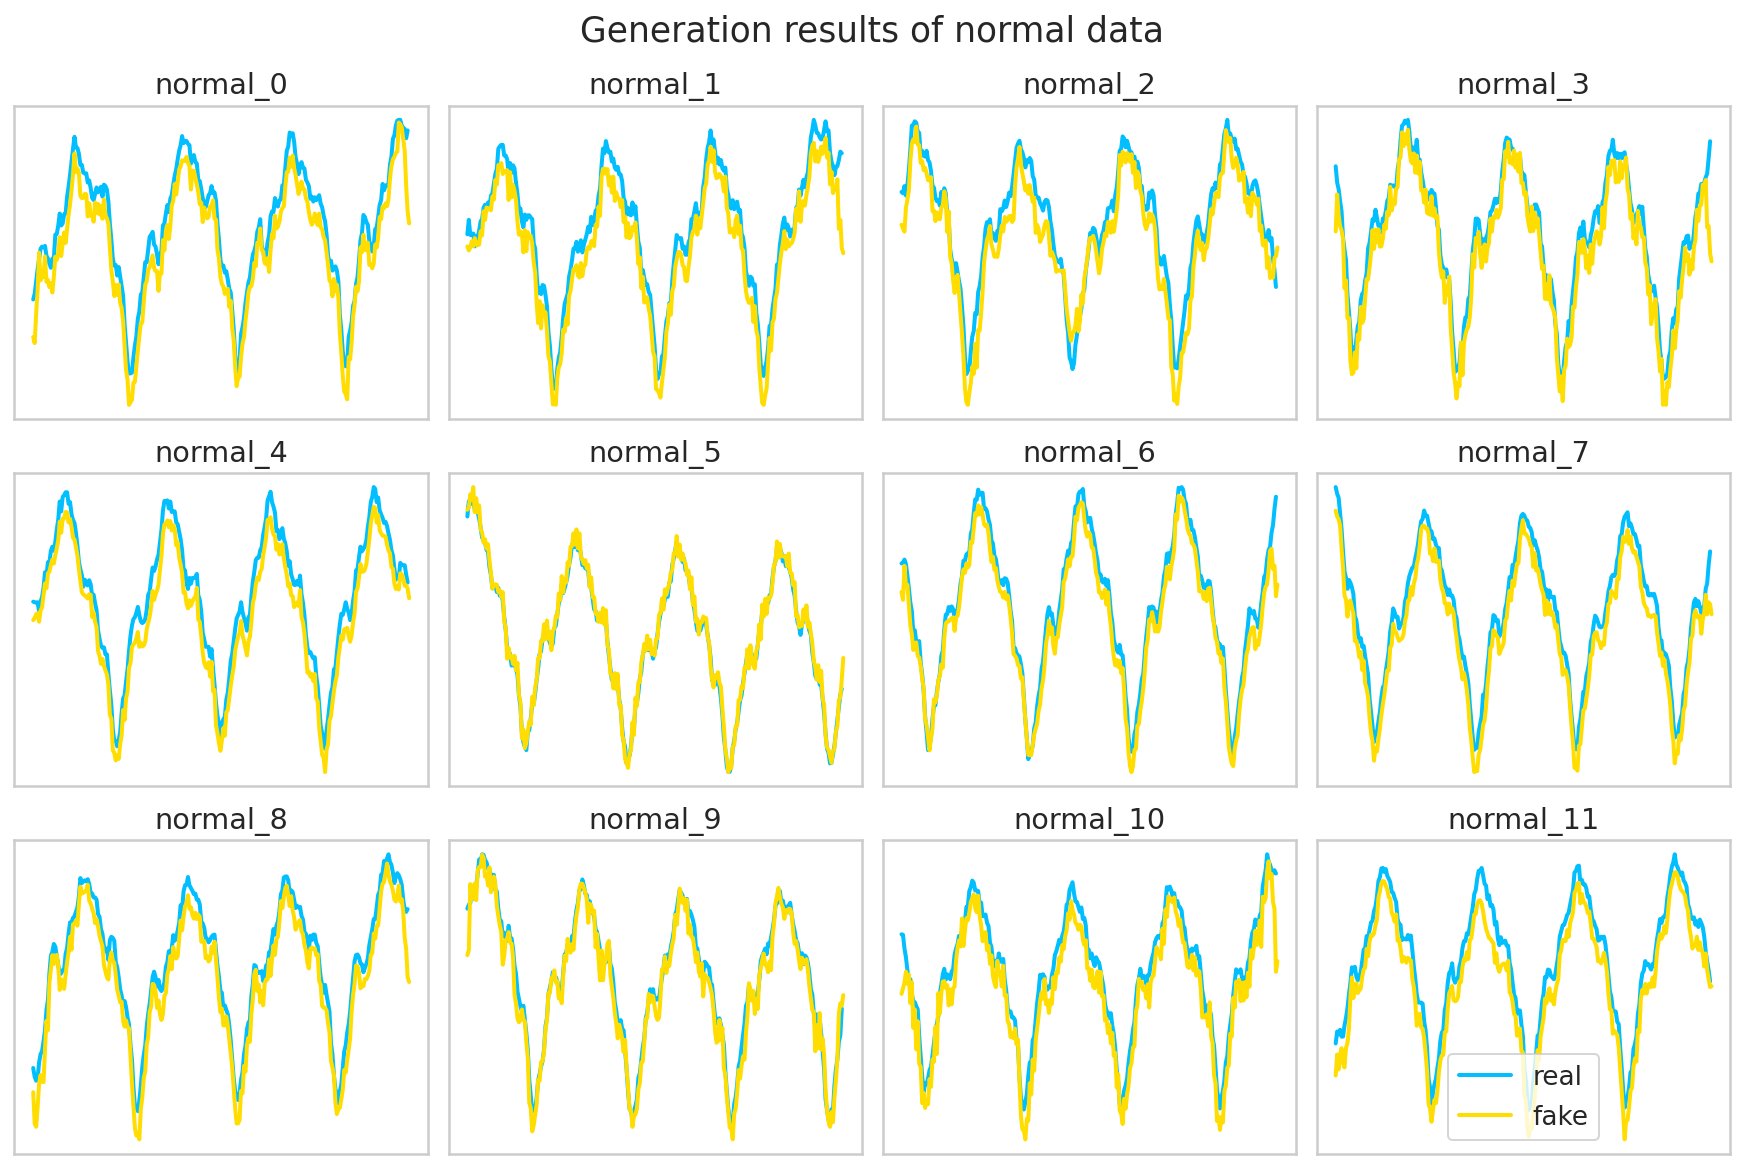

In [115]:
# check the generation performance
nz = 100
test_label = 'normal'
fixed_noise = torch.randn(1, nz, 1)
generator_path = '/content/drive/MyDrive/dataset/checkpoint/WGAN_NEW/netG/'

num_x = 3
num_y = 4
line_width = 2
fig, axs = plt.subplots(nrows=num_x, ncols=num_y, constrained_layout=True)
fig.suptitle('Generation results of {} data'.format(test_label), fontsize='large')
for i in range(num_x):
  for j in range(num_y):
    id = i * num_y + j
    netG_path = os.path.join(generator_path, 'netG_{}_{}.pt'.format(test_label, id))
    g = Generator(nz)
    g.load_state_dict(torch.load(netG_path))
    fake = g(fixed_noise)

    axs[i][j].plot(normal_df.iloc[id,:-1], 
          label = 'real', linewidth=line_width,
          color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
    axs[i][j].plot(np.array(fake.detach().cpu().view(-1)), 
          label = 'fake', linewidth=line_width,
          color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])

    axs[i][j].set_xticks(())
    axs[i][j].set_yticks(())
    axs[i][j].set_title('{}_{}'.format(test_label, id))
plt.legend()
plt.show()

Text(0.5, 0.98, 'Generation results of anomaly data')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'anomaly_0')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'anomaly_1')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'anomaly_2')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'anomaly_3')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'anomaly_4')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'anomaly_5')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'anomaly_6')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'anomaly_7')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'anomaly_8')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'anomaly_9')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'anomaly_10')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'anomaly_11')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'anomaly_12')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'anomaly_13')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'anomaly_14')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'anomaly_15')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'anomaly_16')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'anomaly_17')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'anomaly_18')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'anomaly_19')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'anomaly_20')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'anomaly_21')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'anomaly_22')

<All keys matched successfully>

[]

[]

Text(0.5, 1.0, 'anomaly_23')

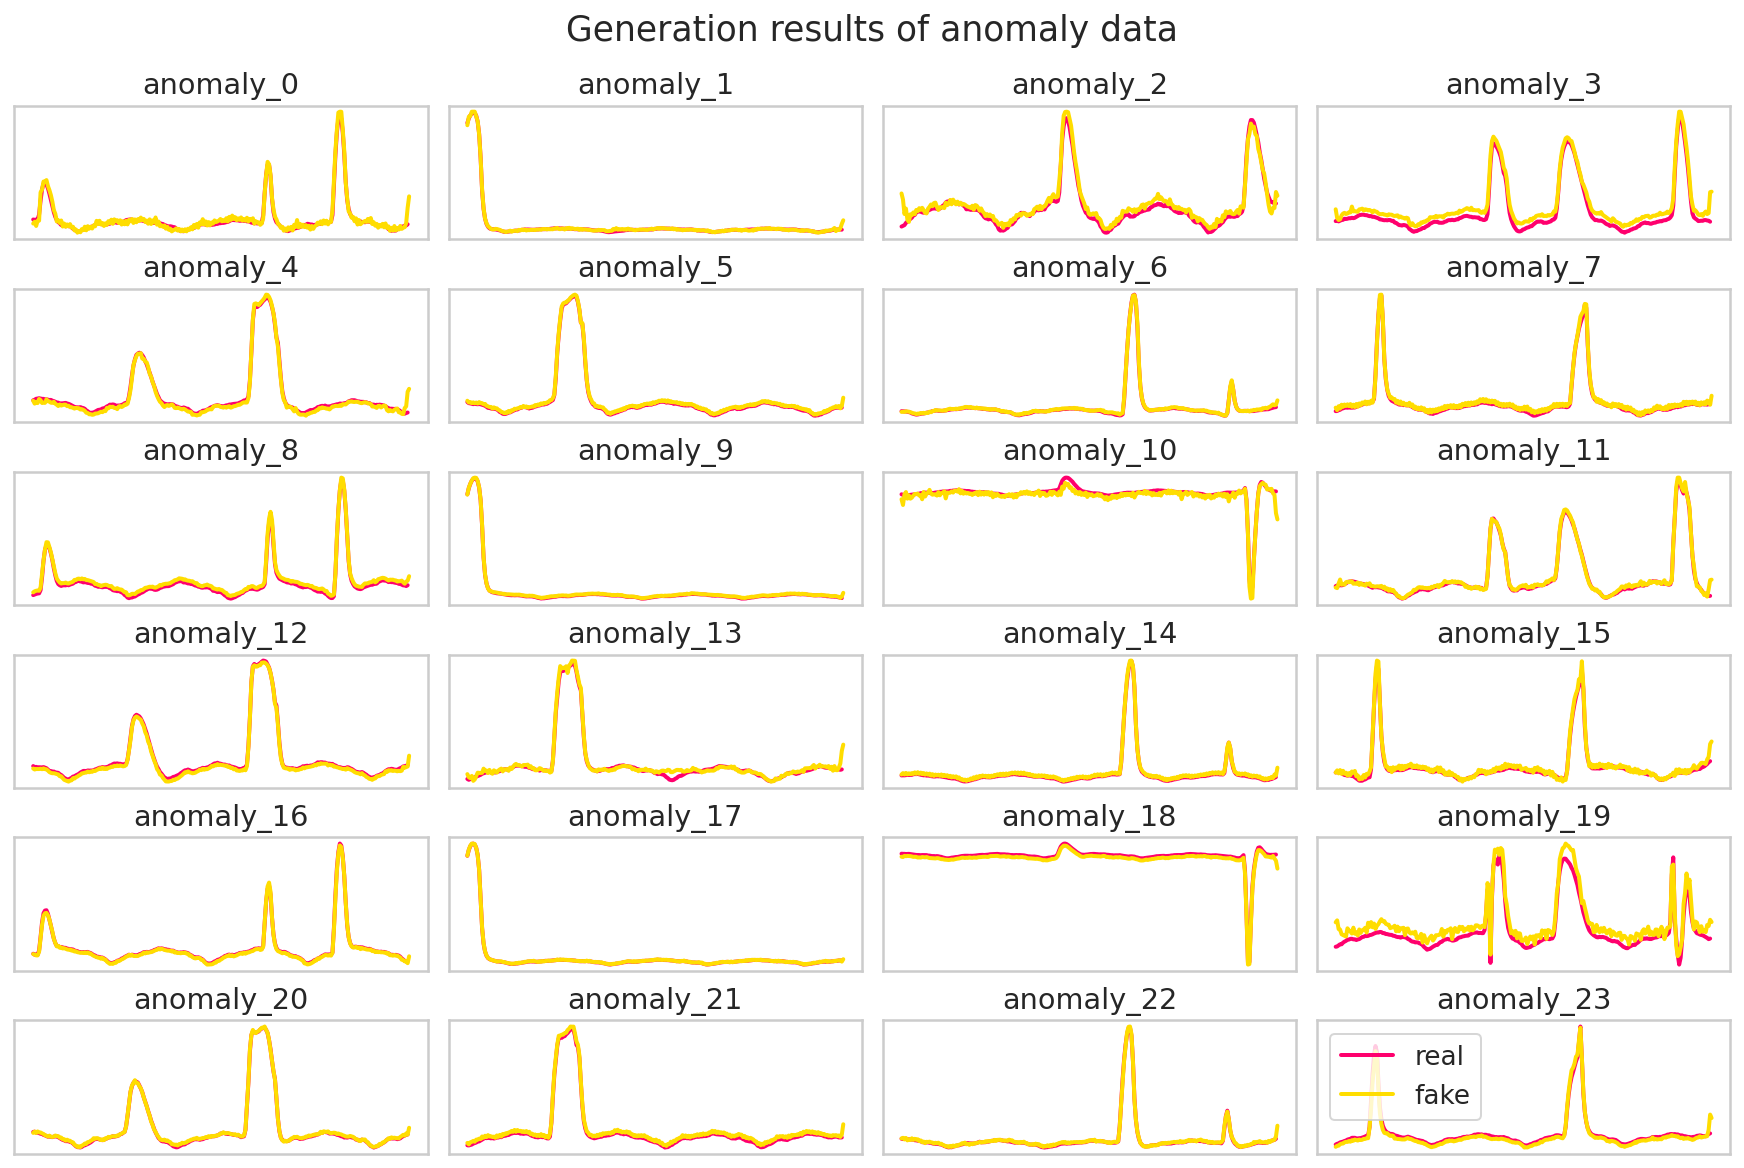

In [116]:
test_label = 'anomaly'
fixed_noise = torch.randn(1, nz, 1)
generator_path = '/content/drive/MyDrive/dataset/checkpoint/WGAN_NEW/netG/'

num_x = 6
num_y = 4
line_width = 2
fig, axs = plt.subplots(nrows=num_x, ncols=num_y, constrained_layout=True)
fig.suptitle('Generation results of {} data'.format(test_label), fontsize='large')
for i in range(num_x):
  for j in range(num_y):
    id = i * num_y + j
    netG_path = os.path.join(generator_path, 'netG_{}_{}.pt'.format(test_label, id))
    g = Generator(nz)
    g.load_state_dict(torch.load(netG_path))
    fake = g(fixed_noise)

    axs[i][j].plot(anomaly_df.iloc[id,:-1], 
          label = 'real', linewidth=line_width,
          color=plt.rcParams['axes.prop_cycle'].by_key()['color'][3])
    axs[i][j].plot(np.array(fake.detach().cpu().view(-1)), 
          label = 'fake', linewidth=line_width,
          color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])

    axs[i][j].set_xticks(())
    axs[i][j].set_yticks(())
    axs[i][j].set_title('{}_{}'.format(test_label, id))
plt.legend()
plt.show()

In [117]:
# 假数据生成10个左右 10+1
all_circle_path  = "drive/MyDrive/dataset/MA_NEW/all_circle_data.csv"
num_fake_data = 100

def generate_fake_dataset(label, id, num_fake_data, path):
  fixed_noise = torch.randn(num_fake_data, nz, 1)
  netG_path = os.path.join('/content/drive/MyDrive/dataset/checkpoint/WGAN_NEW/netG/', 'netG_{}_{}.pt'.format(label, id))
  g = Generator(nz)
  g.load_state_dict(torch.load(netG_path))
  fake = g(fixed_noise)

  result_df = pd.DataFrame()
  for i in range(len(fake)):
    tmp = np.array(fake[i].detach().cpu().view(-1))
    tmp = np.append(tmp, class_to_id[label])
    result_df = result_df.append(pd.DataFrame(tmp).T, ignore_index=True)
  result_df.to_csv(path, index=False, header=False, mode='a+')

In [118]:
# write_circle2csv(all_circle_path, preprocess = True)
# circle_df = pd.read_csv(all_circle_path, header=None)
# circle_df.rename(columns={256: 'target'}, inplace=True)

# for i in range(len(circle_df[circle_df.target==class_to_id['normal']])):
#   generate_fake_dataset('normal', i, num_fake_data, all_circle_path)
# for i in range(len(circle_df[circle_df.target==class_to_id['abnormal']])):
#   generate_fake_dataset('abnormal', i, num_fake_data, all_circle_path)

In [119]:
all_circle_df = pd.read_csv(all_circle_path, header=None)
all_circle_df.rename(columns={256: 'target'}, inplace=True)
all_circle_df

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,target
0,0.364585,0.378472,0.409723,0.439237,0.465280,0.489586,0.494794,0.493057,0.496530,0.472224,...,0.805564,0.807301,0.807301,0.793410,0.788201,0.784729,0.762155,0.781255,0.788201,0.0
1,0.607658,0.640643,0.605922,0.605924,0.609394,0.579881,0.604187,0.598977,0.616339,0.637170,...,0.774322,0.763904,0.743071,0.762168,0.763903,0.777793,0.796892,0.793418,0.802100,0.0
2,0.631942,0.628469,0.645829,0.623262,0.647565,0.685761,0.734370,0.791659,0.793394,0.802076,...,0.517360,0.517361,0.539930,0.513887,0.520834,0.472223,0.442711,0.402778,0.326390,0.0
3,0.127656,0.124119,0.127361,0.127951,0.167750,0.279780,0.370581,0.418047,0.428661,0.410381,...,0.051007,0.053070,0.061620,0.068990,0.072233,0.077539,0.079308,0.089036,0.095228,1.0
4,0.907646,0.944569,0.969495,0.985585,0.992653,0.987631,0.967170,0.917411,0.819011,0.621095,...,0.028368,0.031530,0.031809,0.034320,0.034878,0.034227,0.034506,0.033297,0.034692,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3631,0.011132,0.018910,0.020406,0.031822,0.038015,0.038136,0.049751,0.052903,0.051580,0.058593,...,0.096265,0.084775,0.084899,0.083097,0.083339,0.094461,0.138665,0.256781,0.234860,1.0
3632,0.011148,0.018935,0.020433,0.031875,0.038062,0.038170,0.049761,0.052947,0.051657,0.058787,...,0.094887,0.084183,0.085719,0.085609,0.086066,0.093976,0.139415,0.256701,0.233303,1.0
3633,0.012611,0.020793,0.021905,0.033344,0.038193,0.038000,0.049281,0.052714,0.052233,0.058994,...,0.094348,0.083048,0.085215,0.086374,0.086895,0.093009,0.139543,0.257190,0.233194,1.0
3634,0.008374,0.015171,0.016988,0.028249,0.036782,0.037823,0.050369,0.052878,0.048788,0.057556,...,0.095639,0.082885,0.085144,0.087086,0.088307,0.092073,0.139290,0.254751,0.229159,1.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'normal'), Text(0, 0, 'anomaly')]

Text(-0.050000000000000044, 1212.05, '1212.0')

Text(0.95, 2424.05, '2424.0')

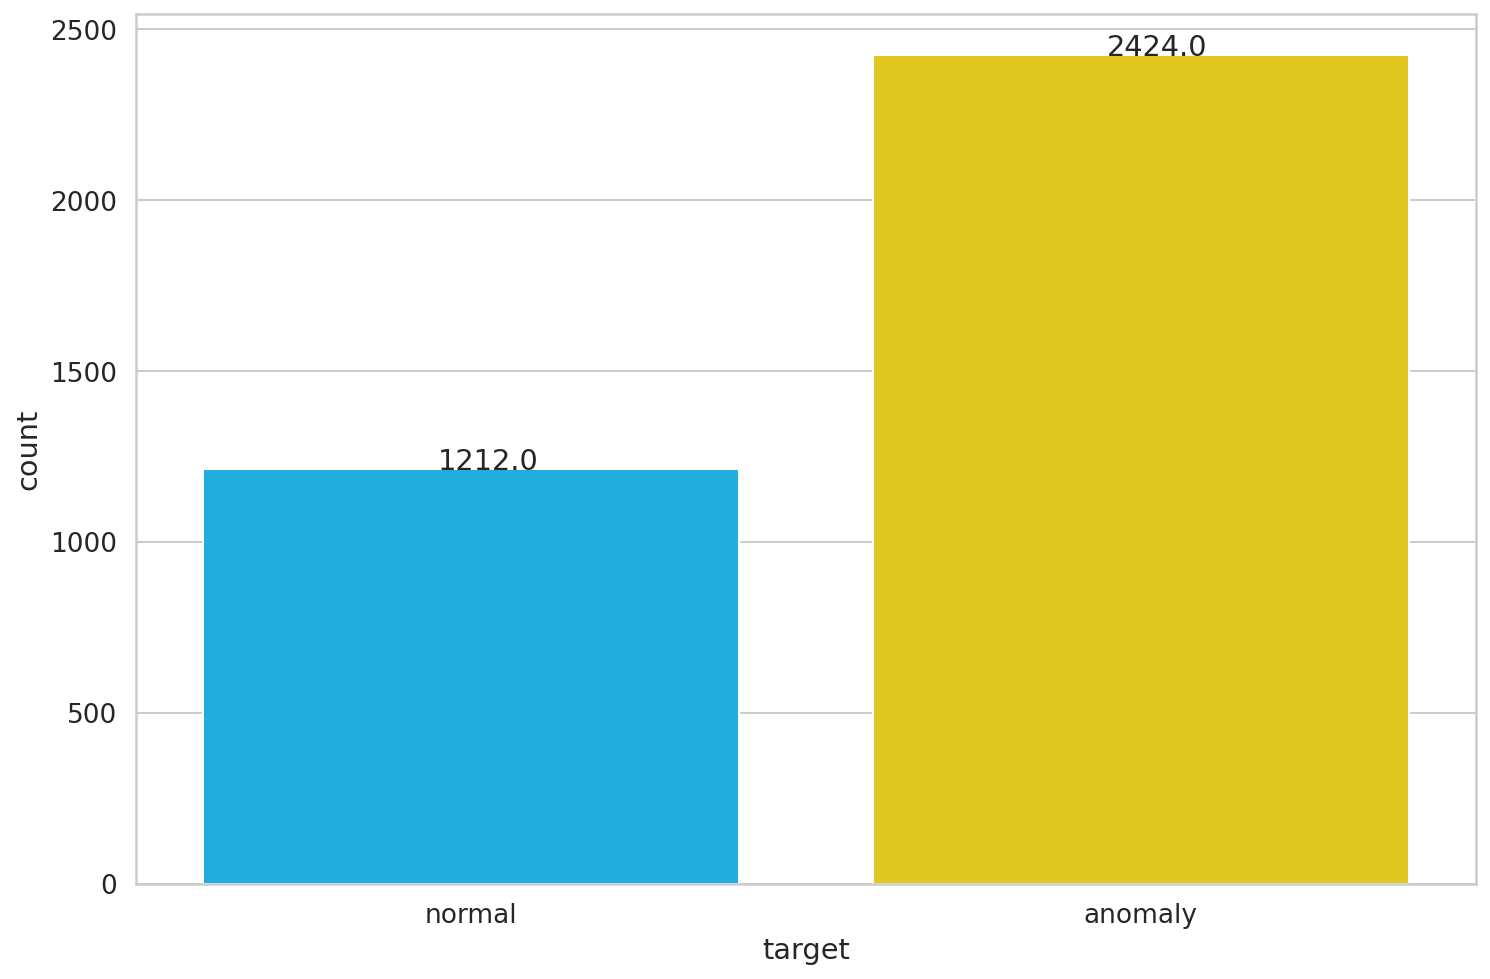

In [120]:
ax = sns.countplot(all_circle_df.target)
ax.set_xticklabels(class_names)
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+0.05))

plt.show()

In [121]:
normal_df = all_circle_df[all_circle_df.target==class_to_id['normal']].drop(labels='target', axis=1)
normal_df

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.364585,0.378472,0.409723,0.439237,0.465280,0.489586,0.494794,0.493057,0.496530,0.472224,...,0.793410,0.805564,0.807301,0.807301,0.793410,0.788201,0.784729,0.762155,0.781255,0.788201
1,0.607658,0.640643,0.605922,0.605924,0.609394,0.579881,0.604187,0.598977,0.616339,0.637170,...,0.795155,0.774322,0.763904,0.743071,0.762168,0.763903,0.777793,0.796892,0.793418,0.802100
2,0.631942,0.628469,0.645829,0.623262,0.647565,0.685761,0.734370,0.791659,0.793394,0.802076,...,0.527778,0.517360,0.517361,0.539930,0.513887,0.520834,0.472223,0.442711,0.402778,0.326390
5,0.781266,0.743070,0.727445,0.699669,0.675363,0.612867,0.585089,0.560786,0.479186,0.439257,...,0.717028,0.718767,0.739597,0.736128,0.743071,0.755222,0.763905,0.800363,0.840292,0.875014
12,0.579680,0.578115,0.576552,0.578117,0.553116,0.579680,0.592178,0.617176,0.659363,0.649989,...,0.639050,0.651551,0.643738,0.684365,0.679677,0.678115,0.678115,0.653115,0.631238,0.604676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1231,0.272338,0.330682,0.282349,0.323159,0.340914,0.302576,0.298497,0.350365,0.376529,0.414677,...,0.613429,0.635291,0.616136,0.605300,0.575625,0.605651,0.562954,0.539113,0.520828,0.523563
1232,0.304337,0.360767,0.322309,0.361898,0.383218,0.340627,0.326604,0.378385,0.383373,0.418682,...,0.603550,0.629883,0.628702,0.618435,0.584287,0.620142,0.575450,0.546222,0.524801,0.525563
1233,0.311198,0.368363,0.328832,0.370782,0.390264,0.347658,0.332176,0.384623,0.388261,0.425907,...,0.648418,0.666855,0.640832,0.633883,0.589989,0.622008,0.575445,0.548967,0.526642,0.528361
1234,0.313526,0.372610,0.332383,0.378432,0.395405,0.354661,0.338410,0.390829,0.387396,0.421345,...,0.637433,0.656178,0.644190,0.635215,0.589709,0.622759,0.580331,0.551306,0.527658,0.529757


In [122]:
anomaly_df = all_circle_df[all_circle_df.target==class_to_id['anomaly']].drop(labels='target', axis=1)
anomaly_df

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
3,0.127656,0.124119,0.127361,0.127951,0.167750,0.279780,0.370581,0.418047,0.428661,0.410381,...,0.038624,0.051007,0.053070,0.061620,0.068990,0.072233,0.077539,0.079308,0.089036,0.095228
4,0.907646,0.944569,0.969495,0.985585,0.992653,0.987631,0.967170,0.917411,0.819011,0.621095,...,0.025113,0.028368,0.031530,0.031809,0.034320,0.034878,0.034227,0.034506,0.033297,0.034692
6,0.108076,0.113934,0.119143,0.136069,0.146485,0.156902,0.166668,0.175783,0.194011,0.197267,...,0.475914,0.421873,0.367836,0.335936,0.307291,0.294920,0.296874,0.281900,0.285156,0.276041
7,0.124290,0.126776,0.122159,0.127486,0.132812,0.134588,0.143111,0.141335,0.143111,0.147727,...,0.124645,0.125710,0.127131,0.126775,0.132457,0.132457,0.129261,0.127485,0.119673,0.113991
8,0.151745,0.155951,0.163463,0.165266,0.167971,0.165567,0.162862,0.162862,0.157454,0.159857,...,0.084438,0.078729,0.074523,0.065809,0.054091,0.049583,0.045677,0.050785,0.054692,0.061603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3631,0.011132,0.018910,0.020406,0.031822,0.038015,0.038136,0.049751,0.052903,0.051580,0.058593,...,0.090271,0.096265,0.084775,0.084899,0.083097,0.083339,0.094461,0.138665,0.256781,0.234860
3632,0.011148,0.018935,0.020433,0.031875,0.038062,0.038170,0.049761,0.052947,0.051657,0.058787,...,0.088526,0.094887,0.084183,0.085719,0.085609,0.086066,0.093976,0.139415,0.256701,0.233303
3633,0.012611,0.020793,0.021905,0.033344,0.038193,0.038000,0.049281,0.052714,0.052233,0.058994,...,0.087570,0.094348,0.083048,0.085215,0.086374,0.086895,0.093009,0.139543,0.257190,0.233194
3634,0.008374,0.015171,0.016988,0.028249,0.036782,0.037823,0.050369,0.052878,0.048788,0.057556,...,0.086773,0.095639,0.082885,0.085144,0.087086,0.088307,0.092073,0.139290,0.254751,0.229159


In [123]:
def get_fake_data(label_name, id, num_fake_data):
  fixed_noise = torch.randn(num_fake_data, nz, 1)
  netG_path = os.path.join('/content/drive/MyDrive/dataset/checkpoint/WGAN_NEW/netG/', 'netG_{}_{}.pt'.format(label_name, id))
  g = Generator(nz)
  g.load_state_dict(torch.load(netG_path))
  fake = g(fixed_noise)

  result_df = pd.DataFrame()
  for i in range(len(fake)):
    tmp = np.array(fake[i].detach().cpu().view(-1))
    tmp = np.append(tmp, class_to_id[label_name])
    result_df = result_df.append(pd.DataFrame(tmp).T, ignore_index=True)
  return result_df

In [124]:
def visualization_compare_real_fake(df, label_name, analysis_type, visualization_type):
    fig, ax = plt.subplots()
    line_width = 1
    id = 5

    real = real_circle_df[real_circle_df.target==class_to_id[label_name]].drop(labels='target', axis=1).iloc[id:id+1,:]
    fake = get_fake_data(label_name, id, 100)
    fake = fake.iloc[:,:-1]

    # rgb = (random.random(), random.random(), random.random())
    # ax.plot(real.iloc[0,:-1], label="Original", c=rgb, linewidth=line_width)

    # rgb = (random.random(), random.random(), random.random())
    # ax.plot(fake.iloc[0,:-1], label="Synthetic", c=rgb, linewidth=line_width)
    # plt.show()

    real_no = len(real)
    fake_no = len(fake)

    seq_len = real.shape[1]

    colors = ["r" for i in range(real_no)] + ["g" for i in range(fake_no)]

    if visualization_type == '3d':
        ax = plt.axes(projection='3d')
    elif visualization_type == '2d':
        fig, ax = plt.subplots()
    if analysis_type == 'pca':
        all = np.concatenate((real, fake), axis=0)

        pca = PCA(n_components=2, random_state=RANDOM_SEED)
        
        # pca_fake_results = pca.fit_transform(fake)
        # pca_real_results = pca.transform(real)
        # ax.scatter(pca_real_results[:, 0],
        #       pca_real_results[:, 1],
        #       c=colors[:real_no],
        #       label="Original")
        # ax.scatter(pca_fake_results[:, 0],
        #       pca_fake_results[:, 1],
        #       c=colors[real_no:],
        #       label="Synthetic")

        pca_results = pca.fit_transform(all)

        ax.scatter(pca_results[:real_no, 0],
              pca_results[:real_no, 1],
              c=colors[:real_no],
              label='real')
        ax.scatter(pca_results[real_no:, 0],
              pca_results[real_no:, 1],
              c=colors[real_no:],
              label="fake")

    elif analysis_type == 'tsne':
        all = np.concatenate((real, fake), axis=0)

        tsne = TSNE(n_components=2, random_state=RANDOM_SEED, n_jobs=-1,
               init='random', learning_rate='auto')
        tsne_results = tsne.fit_transform(all)

        ax.scatter(tsne_results[:real_no, 0],
              tsne_results[:real_no, 1],
              c=colors[:real_no],
              label="real")
        ax.scatter(tsne_results[real_no:, 0],
              tsne_results[real_no:, 1],
              c=colors[real_no:],
              label="fake")
        
    plt.title(analysis_type)
    # plt.axis('off')
    plt.legend()
    plt.show()

In [125]:
# visualization_compare_real_fake(all_circle_df, 'normal', 'pca', '2d')
# visualization_compare_real_fake(all_circle_df, 'normal', 'pca', '3d')

# visualization_compare_real_fake(all_circle_df, 'normal', 'tsne', '2d')
# visualization_compare_real_fake(all_circle_df, 'normal', 'tsne', '3d')

# visualization_compare_real_fake(all_circle_df, 'anomaly', 'pca', '2d')
# visualization_compare_real_fake(all_circle_df, 'anomaly', 'pca', '3d')

# visualization_compare_real_fake(all_circle_df, 'anomaly', 'tsne', '2d')
# visualization_compare_real_fake(all_circle_df, 'anomaly', 'tsne', '3d')

In [126]:
def visualization_compare_normal_abnormal(df, analysis_type, visualization_type):
    if visualization_type == '3d':
        ax = plt.axes(projection='3d')
    elif visualization_type == '2d':
        fig, ax = plt.subplots()

    normal_data = df[df.target==class_to_id['normal']].drop(labels='target', axis=1)
    abnormal_data = df[df.target==class_to_id['abnormal']].drop(labels='target', axis=1)

    normal_no = len(normal_data)
    abnormal_no = len(abnormal_data)
    colors = [plt.rcParams['axes.prop_cycle'].by_key()['color'][0] for i in range(normal_no)] + [plt.rcParams['axes.prop_cycle'].by_key()['color'][3] for i in range(abnormal_no)]

    if analysis_type == 'pca':       
        all = np.concatenate((normal_data, abnormal_data), axis=0)
        pca = PCA(n_components=2, random_state=RANDOM_SEED)

        # pca_results = pca.fit_transform(all)

        # ax.scatter(pca_results[:normal_no, 0],
        #       pca_results[:normal_no, 1],
        #       c=colors[:normal_no],
        #       label='normal')
        # ax.scatter(pca_results[normal_no:, 0],
        #       pca_results[normal_no:, 1],
        #       c=colors[normal_no:],
        #       label="abnormal")
        
        pca_normal_results = pca.fit_transform(normal_data)
        pca_abnormal_results = pca.transform(abnormal_data)
        
        ax.scatter(pca_normal_results[:, 0],
              pca_normal_results[:, 1],
              c=colors[:normal_no],
              label="normal")
        ax.scatter(pca_abnormal_results[:, 0],
              pca_abnormal_results[:, 1],
              c=colors[normal_no:],
              label="anomaly")

    elif analysis_type == 'tsne':
        all = np.concatenate((normal_data, abnormal_data), axis=0)
        tsne = TSNE(n_components=2, random_state=RANDOM_SEED, n_jobs=-1,
               init='random', learning_rate='auto')
        tsne_results = tsne.fit_transform(all)

        ax.scatter(tsne_results[:normal_no, 0],
              tsne_results[:normal_no, 1],
              c=colors[:normal_no],
              label='normal')
        ax.scatter(tsne_results[normal_no:, 0],
              tsne_results[normal_no:, 1],
              c=colors[normal_no:],
              label="anomaly")

    plt.title(analysis_type)
    # plt.axis('off')
    plt.legend()
    plt.show()

In [127]:
# visualization_compare_normal_abnormal(all_circle_df, 'pca', '2d')
# visualization_compare_normal_abnormal(all_circle_df, 'pca', '3d')

# visualization_compare_normal_abnormal(all_circle_df, 'tsne', '3d')
# visualization_compare_normal_abnormal(all_circle_df, 'tsne', '2d')

# Autoencoder

In [128]:
df = all_circle_df


anomaly_df = df[df.target==class_to_id['anomaly']]
normal_df = df[df.target==class_to_id['normal']]

train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

_, test_df = train_test_split(
  val_df,
  test_size=0.33,
  random_state=RANDOM_SEED
)

print('Shape of train data: ' + str(train_df.shape))
print('Shape of validation data: ' + str(val_df.shape))
print('Shape of test data: ' + str(test_df.shape))

print('Shape of anomaly data: ' + str(anomaly_df.shape))
print('Shape of normal data: ' + str(normal_df.shape))

Shape of train data: (1030, 257)
Shape of validation data: (182, 257)
Shape of test data: (61, 257)
Shape of anomaly data: (2424, 257)
Shape of normal data: (1212, 257)


In [129]:
def create_cycle_dataset(df):
  x_values = []
  y_values = []
  for i in range(len(df)):
    x = df.iloc[i,:-1].values
    y = df.iloc[i,-1]
    x_values.append(x)
    y_values.append(y)

  x = [torch.tensor(x).unsqueeze(1).float() for x in x_values]
  y = [torch.tensor(y).unsqueeze(0).float() for y in y_values]
  x = torch.stack(x)
  y = torch.stack(y)

  n_seq, seq_len, n_features = x.shape
  return x, y, seq_len, n_features

X, Y, seq_len, n_features = create_cycle_dataset(df)
trainX, trainY, seq_len, n_features = create_cycle_dataset(train_df)
valX, valY, _, _ = create_cycle_dataset(val_df)
testX, testY, _, _ = create_cycle_dataset(test_df)

test_anomaly_X, test_anomaly_Y, _, _ = create_cycle_dataset(anomaly_df)
test_normal_X, test_normal_Y, _, _ = create_cycle_dataset(normal_df)

print('Shape of train data: ' + str(trainX.shape))
print('Shape of validation data: ' + str(valX.shape))
print('Shape of test data: ' + str(testX.shape))

print('Shape of anomaly data: ' + str(test_anomaly_X.shape))
print('Shape of normal data: ' + str(test_normal_X.shape))

Shape of train data: torch.Size([1030, 256, 1])
Shape of validation data: torch.Size([182, 256, 1])
Shape of test data: torch.Size([61, 256, 1])
Shape of anomaly data: torch.Size([2424, 256, 1])
Shape of normal data: torch.Size([1212, 256, 1])


In [130]:
batch_size = 64

Dataset = TensorDataset(X, Y)
Dataloader = DataLoader(Dataset, batch_size=batch_size, shuffle=True)

trainDataset = TensorDataset(trainX, trainY)
trainDataloader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True)

valDataset = TensorDataset(valX, valY)
valDataloader = DataLoader(valDataset, batch_size=batch_size, shuffle=True)

testDataset = TensorDataset(testX, testY)
testDataloader = DataLoader(testDataset, batch_size=batch_size, shuffle=True)

testAnomalyDataset = TensorDataset(test_anomaly_X, test_anomaly_Y)
testAnomalyDataloader = DataLoader(testAnomalyDataset, batch_size=batch_size, shuffle=True)

testNormalDataset = TensorDataset(test_normal_X, test_normal_Y)
testNormalDataloader = DataLoader(testNormalDataset, batch_size=batch_size, shuffle=True)

In [131]:
class LstmAutoencoder1(nn.Module):
  def __init__(
    self,
    input_size=1,
    seq_len=256,
    dropout=0.2,
    embedding_dim=8
  ):
    super().__init__()
    self.sequence_length = seq_len
    self.input_dim = input_size  # 1
    self.embedding_dim = embedding_dim
    self.dropout = dropout

    self.lstm1 = nn.LSTM(
      input_size = self.input_dim,
      hidden_size = self.embedding_dim,
      num_layers = 1,
      batch_first = True
    )
    self.bn1 = nn.BatchNorm1d(self.embedding_dim)   

    self.linear1 = nn.Linear(self.embedding_dim*self.sequence_length, self.input_dim*self.sequence_length)
    self.bn4 = nn.BatchNorm1d(self.input_dim*self.sequence_length)

    self.dropout = nn.Dropout(self.dropout)
        
  def forward(self, x):
    output, (_, _) = self.lstm1(x)
    output = self.dropout(self.bn1(output.permute(0,2,1)).permute(0,2,1))

    output = self.bn4(self.linear1(output.reshape(output.shape[0],-1)))
    return output.unsqueeze(2)

In [132]:
class LstmAutoencoder2(nn.Module):
  def __init__(
    self,
    input_size=1,
    seq_len=256,
    dropout=0.2,
    embedding_dim=8
  ):
    super().__init__()
    self.sequence_length = seq_len
    self.input_dim = input_size  # 1
    self.embedding_dim = embedding_dim
    self.dropout = dropout

    self.lstm1 = nn.LSTM(
      input_size = self.input_dim,
      hidden_size = self.embedding_dim,
      num_layers = 1,
      batch_first = True
    )
    self.bn1 = nn.BatchNorm1d(self.embedding_dim)

    self.lstm2 = nn.LSTM(
      input_size = self.embedding_dim,
      hidden_size = self.embedding_dim*2,
      num_layers = 1,
      batch_first = True
    )
    self.bn2 = nn.BatchNorm1d(self.embedding_dim*2)

    
    self.linear1 = nn.Linear(self.embedding_dim*2 * self.sequence_length, self.input_dim * self.sequence_length)
    self.bn4 = nn.BatchNorm1d(self.input_dim * self.sequence_length)

    self.relu = torch.nn.ReLU()
    self.dropout = nn.Dropout(self.dropout)
        
  def forward(self, x):
    output, (_, _) = self.lstm1(x)
    output = self.dropout(self.bn1(output.permute(0,2,1)).permute(0,2,1))
    # print(output.shape)
    output, (_, _) = self.lstm2(output)
    output = self.dropout(self.bn2(output.permute(0,2,1)).permute(0,2,1))
    # print(output.shape)
    output = self.bn4(self.linear1(output.reshape(output.shape[0],-1)))
    # print(output.shape)
    return output.unsqueeze(2)

In [133]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
      nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
      nn.init.normal_(m.weight.data, 1.0, 0.02)
      nn.init.constant_(m.bias.data, 0)

class CnnAutoencoder(nn.Module):
  def __init__(
    self,
    seq_len=256,
    input_size=1,
    num_kernal=176,
    kernel_size=4,
  ):
    super().__init__()

    self.num_kernal = num_kernal
    self.kernel_size = kernel_size
    
    super().__init__()
    self.enc_layer1 = self.Conv1d_block(in_channels = 1, out_channels = self.num_kernal, kernel_size = self.kernel_size)
    self.enc_layer2 = self.Conv1d_block(in_channels = self.num_kernal, out_channels = self.num_kernal*2, kernel_size = self.kernel_size)
    self.enc_layer3 = self.Conv1d_block(in_channels = self.num_kernal*2, out_channels = self.num_kernal*4, kernel_size = self.kernel_size)
    
    self.dec_layer4 = self.ConvTranspose1d(in_channels = self.num_kernal*4, out_channels = self.num_kernal*2, kernel_size = self.kernel_size)
    self.dec_layer5 = self.ConvTranspose1d(in_channels = self.num_kernal*2, out_channels = self.num_kernal, kernel_size = self.kernel_size)
    self.dec_layer6 = self.ConvTranspose1d(in_channels = self.num_kernal, out_channels = 1, kernel_size = self.kernel_size+2)

    self.relu = torch.nn.ReLU()
    self.leakyRelu = nn.LeakyReLU(0.2, inplace=True)

  def Conv1d_block(self, in_channels, out_channels, kernel_size, stride=2, padding=0):
    return nn.Sequential(
      nn.Conv1d(
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        bias=False,
      ),
      nn.BatchNorm1d(out_channels),
      nn.LeakyReLU(0.2, inplace=True),
    )
  def ConvTranspose1d(self, in_channels, out_channels, kernel_size, stride=2, padding=0):
    return nn.Sequential(
      nn.ConvTranspose1d(
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        bias=False,
      ),
      nn.BatchNorm1d(out_channels),
      nn.LeakyReLU(0.2, inplace=True),
    )      
  def forward(self, x):
    output = x.permute(0,2,1)
    # print(output.shape)
    output = self.enc_layer1(output)
    # print(output.shape)
    output = self.enc_layer2(output)
    # print(output.shape)
    output = self.enc_layer3(output)
    # print(output.shape)
    output = self.dec_layer4(output)
    # print(output.shape)
    output = self.dec_layer5(output)
    # print(output.shape)
    output = self.dec_layer6(output)
    # print(output.shape)
    output = output.permute(0,2,1)
    # print(output.shape)
    return output    

In [134]:
class LinearLstmAutoencoder(nn.Module):
  def __init__(
    self,
    input_size=1,
    seq_len=256
  ):
    super().__init__()
    self.sequence_length = seq_len
    self.input_dim = input_size  # 1
    self.embedding_dim = 52

    self.linear1 = nn.Linear(self.sequence_length, round(self.sequence_length/2))
    self.bn1 = nn.BatchNorm1d(round(self.sequence_length/2))
    self.linear2 = nn.Linear(round(self.sequence_length/2), round(self.sequence_length/4))
    self.bn2 = nn.BatchNorm1d(round(self.sequence_length/4))

    self.bn3 = nn.BatchNorm1d(self.embedding_dim)
    self.relu = torch.nn.ReLU()
    

    self.lstm1 = nn.LSTM(
      input_size = self.embedding_dim,
      hidden_size = self.embedding_dim,
      num_layers = 1,
      batch_first = True
    )
    self.bn4 = nn.BatchNorm1d(self.embedding_dim)

    self.lstm2 = nn.LSTM(
      input_size = self.embedding_dim,
      hidden_size = self.input_dim,
      num_layers = 1,
      batch_first = True
    )
    self.bn5 = nn.BatchNorm1d(self.input_dim)

    self.linear3 = nn.Linear(round(self.sequence_length/4), round(self.sequence_length/2))
    self.bn6 = nn.BatchNorm1d(round(self.sequence_length/2))
    self.linear4 = nn.Linear(round(self.sequence_length/2), self.sequence_length)
    self.bn7 = nn.BatchNorm1d(self.sequence_length)
        
  def forward(self, x):
    output = self.relu(self.bn1(self.linear1(x.squeeze(2))))
    # print(output.shape)
    output = self.bn2(self.linear2(output))
    # print(output.shape)
    output = self.bn3(output.unsqueeze(2).repeat(1, 1, self.embedding_dim).permute(0,2,1)).permute(0,2,1)
    print(output.shape)

    output, (_, _) = self.lstm1(output)  #torch.Size([6, 64, 52])
    output = self.bn4(output.permute(0,2,1)).permute(0,2,1)
    print(output.shape)

    output, (_, _) = self.lstm2(output)
    output = self.relu(self.bn5(output.permute(0,2,1)).permute(0,2,1))
    print(output.shape)
    
    output = self.relu(self.bn6(self.linear3(output.squeeze(2))))
    print(output.shape)
    output = self.linear4(output)
    print(output.shape)
    return output.unsqueeze(2)

In [135]:
class Chomp1d(nn.Module):
  def __init__(self, chomp_size):
    super(Chomp1d, self).__init__()
    self.chomp_size = chomp_size

  def forward(self, x):
    """
    其实这就是一个裁剪的模块，裁剪多出来的padding
    """
    return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
  def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
    """
    相当于一个Residual block

    :param n_inputs: int, 输入通道数
    :param n_outputs: int, 输出通道数
    :param kernel_size: int, 卷积核尺寸
    :param stride: int, 步长，一般为1
    :param dilation: int, 膨胀系数
    :param padding: int, 填充系数
    :param dropout: float, dropout比率
    """
    super(TemporalBlock, self).__init__()
    self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                stride=stride, padding=padding, dilation=dilation))
    # 经过conv1，输出的size其实是(Batch, input_channel, seq_len + padding)
    self.chomp1 = Chomp1d(padding)  # 裁剪掉多出来的padding部分，维持输出时间步为seq_len
    self.relu1 = nn.ReLU()
    self.dropout1 = nn.Dropout(dropout)

    self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                 stride=stride, padding=padding, dilation=dilation))
    self.chomp2 = Chomp1d(padding)  #  裁剪掉多出来的padding部分，维持输出时间步为seq_len
    self.relu2 = nn.ReLU()
    self.dropout2 = nn.Dropout(dropout)

    self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                              self.conv2, self.chomp2, self.relu2, self.dropout2)
    self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
    self.relu = nn.ReLU()
    self.init_weights()

  def init_weights(self):
    """
    参数初始化

    :return:
    """
    self.conv1.weight.data.normal_(0, 0.01)
    self.conv2.weight.data.normal_(0, 0.01)
    if self.downsample is not None:
      self.downsample.weight.data.normal_(0, 0.01)

  def forward(self, x):
    """
    :param x: size of (Batch, input_channel, seq_len)
    :return:
    """
    out = self.net(x)
    res = x if self.downsample is None else self.downsample(x)
    return self.relu(out + res)


class TemporalConvNet(nn.Module):
  def __init__(self, num_inputs=1, num_channels=[20,20,20,20], kernel_size=20, dropout=0.2):
    """
    TCN，目前paper给出的TCN结构很好的支持每个时刻为一个数的情况，即sequence结构，
    对于每个时刻为一个向量这种一维结构，勉强可以把向量拆成若干该时刻的输入通道，
    对于每个时刻为一个矩阵或更高维图像的情况，就不太好办。

    :param num_inputs: int， 输入通道数
    :param num_channels: list，每层的hidden_channel数，例如[25,25,25,25]表示有4个隐层，每层hidden_channel数为25
    :param kernel_size: int, 卷积核尺寸
    :param dropout: float, drop_out比率
    """
    super(TemporalConvNet, self).__init__()
    layers = []
    num_levels = len(num_channels)
    for i in range(num_levels):
        dilation_size = 2 ** i   # 膨胀系数：1，2，4，8……
        in_channels = num_inputs if i == 0 else num_channels[i-1]  # 确定每一层的输入通道数
        out_channels = num_channels[i]  # 确定每一层的输出通道数
        layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                  padding=(kernel_size-1) * dilation_size, dropout=dropout)]

    self.network = nn.Sequential(*layers)

  def forward(self, x):
    """
    输入x的结构不同于RNN，一般RNN的size为(Batch, seq_len, channels)或者(seq_len, Batch, channels)，
    这里把seq_len放在channels后面，把所有时间步的数据拼起来，当做Conv1d的输入尺寸，实现卷积跨时间步的操作，
    很巧妙的设计。
    
    :param x: size of (Batch, input_channel, seq_len)
    :return: size of (Batch, output_channel, seq_len)
    """
    return self.network(x)


class TcnAutoencoder(nn.Module):
  def __init__(
    self,
    seq_len=256,
  ):
    super().__init__()


    self.num_kernal = 30
    self.num_layel = 4
    # self.num_channels = [20,20,20,20]
    self.num_channels = [self.num_kernal for i in range(self.num_layel)]

    # self.kernal_size = 20
    self.kernal_size = 30
    self.dropout_rate = 0.2

    # self.out_channels = 8
    self.out_channels = 24
    # self.pool_size = 42
    self.pool_size = 22



    self.en_tcn = TemporalConvNet(num_inputs=1, 
                    num_channels = self.num_channels, 
                    kernel_size = self.kernal_size, 
                    dropout = self.dropout_rate)
    self.en_conv = self.Conv1d_block(in_channels = self.num_kernal, 
                    out_channels = self.out_channels, 
                    kernel_size = 1)

    self.de_tcn = TemporalConvNet(num_inputs = self.out_channels, 
                    num_channels = self.num_channels, 
                    kernel_size = self.kernal_size, 
                    dropout = self.dropout_rate)
    self.de_conv = self.Conv1d_block(in_channels = self.num_kernal, 
                    out_channels = 1, 
                    kernel_size = 1)

    self.pool = nn.AvgPool1d(self.pool_size)
    self.upsample = nn.Upsample(size = seq_len, mode='nearest')

  def Conv1d_block(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
    return nn.Sequential(
      nn.Conv1d(
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        bias=False,
      ),
      nn.BatchNorm1d(out_channels),
    )      
  def forward(self, x):
    output = x.permute(0,2,1)
    print(output.shape)
    output = self.en_tcn(output)
    print(output.shape)
    output = self.en_conv(output)
    print(output.shape)
    output = self.pool(output)
    print(output.shape)
    output = self.upsample(output)
    # print(output.shape)
    output = self.de_tcn(output)
    # print(output.shape)
    output = self.de_conv(output)
    # print(output.shape)
    output = output.permute(0,2,1)
    return output 

In [136]:
class CnnLstmAutoencoder(nn.Module):
  def __init__(
    self,
    input_size=1,
    seq_len=256,
    num_kernal=8,
    kernel_size=3,
    dropout=0.2
  ):
    super().__init__()
    self.sequence_len = seq_len
    self.input_dim = input_size  # 1
    self.num_kernal = num_kernal
    self.kernel_size = kernel_size
    self.dropout = dropout
    self.relu = torch.nn.ReLU()
    self.leakyRelu = nn.LeakyReLU(0.2, inplace=True)
    self.dropout = nn.Dropout(self.dropout) 

    self.enc_layer1 = self.Conv1d_block(in_channels = 1, out_channels = self.num_kernal, kernel_size = self.kernel_size)
    self.enc_layer2 = self.Conv1d_block(in_channels = self.num_kernal, out_channels = self.num_kernal*2, kernel_size = self.kernel_size)

    # out_features = int((self.sequence_len - self.kernel_size + 1)/2+0.5)
    # out_features = int((out_features - self.kernel_size + 1)/2+0.5)
    self.out_features = int((self.sequence_len - self.kernel_size + 1)/1+0.5)
    self.out_features = int((self.out_features - 2 + 1)/2+0.5)
    self.out_features = int((self.out_features - self.kernel_size + 1)/1+0.5)
    self.out_features = int((self.out_features - 2 + 1)/2+0.5)
    self.embedding_dim = self.out_features

    self.lstm1 = nn.LSTM(   # (batch, seq, input_size)
      input_size = self.embedding_dim,
      hidden_size = round(self.embedding_dim/2),
      num_layers = 1,
      batch_first = True
    )
    self.bn1 = nn.BatchNorm1d(round(self.embedding_dim/2))

    self.lstm2 = nn.LSTM(  
      input_size = round(self.embedding_dim/2),
      hidden_size = self.embedding_dim,
      num_layers = 1,
      batch_first = True
    )
    self.bn2 = nn.BatchNorm1d(self.embedding_dim)

    self.linear3 = nn.Linear(self.num_kernal*2*self.embedding_dim, self.sequence_len)
    self.bn3 = nn.BatchNorm1d(self.sequence_len)

    # self.linear3 = nn.Linear(round(self.sequence_len/4), round(self.sequence_len/2))
    # self.bn3 = nn.BatchNorm1d(round(self.sequence_len/2))

    # self.linear4 = nn.Linear(round(self.sequence_len/2), self.sequence_len)
    # self.bn4 = nn.BatchNorm1d(self.sequence_len)


  def Conv1d_block(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
    return nn.Sequential(
      nn.Conv1d(
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        bias=False,
      ),
      nn.BatchNorm1d(out_channels),
      nn.LeakyReLU(0.2, inplace=True),
      nn.MaxPool1d(2)
    )
        
  def forward(self, x):
    output = x.permute(0,2,1)
    output = self.dropout(self.enc_layer1(output))
    output = self.dropout(self.enc_layer2(output))
    # print(output.shape)

    output, (_, _) = self.lstm1(output)  #torch.Size([6, 64, 52])
    output = self.bn1(output.permute(0,2,1)).permute(0,2,1)
    # print(output.shape)

    output, (_, _) = self.lstm2(output)  #torch.Size([6, 64, 52])
    output = self.bn2(output.permute(0,2,1)).permute(0,2,1)
    # print(output.shape)

    output = self.bn3(self.linear3(output.reshape(output.shape[0],-1)))
    # output = self.bn4(self.linear4(output))

    return output.unsqueeze(2)
    # return output

In [137]:
# model = CnnAutoencoder().to(device)
# model.apply(weights_init)

# model = TcnAutoencoder().to(device)

# model = LinearLstmAutoencoder().to(device)

model = CnnLstmAutoencoder(num_kernal=32).to(device)

# model = LstmAutoencoder1(embedding_dim=16).to(device)
# model = LstmAutoencoder2(embedding_dim=16).to(device)

model

CnnLstmAutoencoder(
  (relu): ReLU()
  (leakyRelu): LeakyReLU(negative_slope=0.2, inplace=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (enc_layer1): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc_layer2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm1): LSTM(62, 31, batch_first=True)
  (bn1): BatchNorm1d(31, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm2): LSTM(31, 62, batch_first=True)
  (bn2): BatchNorm1d(62, eps=1e-05, mom

In [138]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

# criterion = nn.L1Loss(reduction='sum').to(device)
criterion = nn.MSELoss(reduction='sum').to(device)

In [139]:
def predict(model, dataloader):
  losses = []
  with torch.no_grad():
    model = model.eval()
    for id_batch, (x_batch, _) in enumerate(dataloader):
      x_batch = x_batch.to(device)
      x_pred = model(x_batch)
      diff = ((x_pred - x_batch)**2).sum(1)
      losses.append(diff.squeeze().tolist())

      if id_batch == 0 :
        predictions = x_pred
        originals = x_batch
      else:
        predictions = torch.cat((predictions,x_pred), 0)
        originals = torch.cat((originals,x_batch), 0)

  losses = [x for xs in losses for x in xs]
  return originals, predictions, losses

In [140]:
def train_model(model, train_dataset, val_dataset, n_epochs, patience):
  # to track the average training loss and validation loss per epoch as the model trains
  history = dict(train=[], val=[])
  # to save the current best model states
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  best_correct = 0
  best_threshold = 0

  # initialize the early_stopping object
  early_stopping = EarlyStopping(verbose = True, patience = patience)

  flag = False
  for epoch in range(1, n_epochs + 1):

    ###################
    # train the model #
    ###################
    model = model.train()
    train_losses = []
    for id_batch, (x_batch, y_batch) in enumerate(trainDataloader):
      # clear the gradients of all optimized variables
      optimizer.zero_grad()
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      # forward pass: compute predicted outputs by passing inputs to the model
      seq_pred = model(x_batch)
      # calculate the loss
      loss = criterion(seq_pred, x_batch)
      loss = loss / x_batch.shape[0]
      # backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()
      # perform a single optimization step (parameter update)
      optimizer.step()
      # record training loss
      loss = loss.item()
      train_losses.append(loss)

    ######################    
    # validate the model #
    ######################
    model = model.eval()
    val_losses = []
    with torch.no_grad():
      for id_batch, (x_batch, y_batch) in enumerate(valDataloader):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        seq_pred = model(x_batch)
        #  calculate the loss
        loss = criterion(seq_pred, x_batch)
        # record validation loss
        loss = loss / x_batch.shape[0]
        loss = loss.item()
        val_losses.append(loss)

      if np.mean(val_losses) < 0.1:
        flag = True
      if flag == True:
        correct = 0
        originals_normal, predictions_normal, pred_losses_normal = predict(model, testNormalDataloader)
        originals_left, predictions_left, pred_losses_left = predict(model, testAnomalyDataloader)
        num_all_sammples = len(pred_losses_left) + len(pred_losses_normal)
        THRESHOLD = linspace(0.0,0.5,500)
        for threshold in THRESHOLD:
          correct = sum(i > threshold for i in pred_losses_left) + sum(i <= threshold for i in pred_losses_normal)
          correct = correct / num_all_sammples

          if correct >= best_correct:
            best_correct = correct
            best_threshold = threshold
            best_model_wts = copy.deepcopy(model.state_dict())
      if best_correct == 1.0:
        break
    # calculate average loss over an epoch
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    # early_stopping(val_loss, model)
    # if early_stopping.early_stop:
    #   print("Early stopping")
    #   break

    # if val_loss < best_loss:
    #   best_loss = val_loss
    #   best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch: {epoch} train loss {train_loss} val loss {val_loss} best_correct {best_correct}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history, best_threshold

In [141]:
# # number of epochs.
# n_epochs=500

# # early stopping patience; how long to wait after last time validation loss improved.
# patience = 50

# model, history, best_threshold = train_model(
#   model, 
#   trainX,
#   valX,
#   n_epochs=n_epochs,
#   patience=patience
# )

In [ ]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'])
plt.title('Loss over training epochs')
plt.show()

In [149]:
model = CnnAutoencoder().to(device)
model.apply(weights_init)

# model = TcnAutoencoder().to(device)

# model = LinearLstmAutoencoder().to(device)

# model = CnnLstmAutoencoder(num_kernal=32).to(device)

# model = LstmAutoencoder1(embedding_dim=16).to(device)
# model = LstmAutoencoder2(embedding_dim=16).to(device)

CnnAutoencoder(
  (enc_layer1): Sequential(
    (0): Conv1d(1, 176, kernel_size=(4,), stride=(2,), bias=False)
    (1): BatchNorm1d(176, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (enc_layer2): Sequential(
    (0): Conv1d(176, 352, kernel_size=(4,), stride=(2,), bias=False)
    (1): BatchNorm1d(352, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (enc_layer3): Sequential(
    (0): Conv1d(352, 704, kernel_size=(4,), stride=(2,), bias=False)
    (1): BatchNorm1d(704, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (dec_layer4): Sequential(
    (0): ConvTranspose1d(704, 352, kernel_size=(4,), stride=(2,), bias=False)
    (1): BatchNorm1d(352, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
 

In [150]:
MODEL_PATH = '/content/drive/MyDrive/dataset/checkpoint/cnn_ae_all_new.pth'
# MODEL_PATH = '/content/drive/MyDrive/dataset/checkpoint/tcn_ae_all_new.pth'
# MODEL_PATH = '/content/drive/MyDrive/dataset/checkpoint/linear_lstm_ae_all_new.pth'
# MODEL_PATH = '/content/drive/MyDrive/dataset/checkpoint/cnn_lstm_ae_all_new.pth'
# MODEL_PATH = '/content/drive/MyDrive/dataset/checkpoint/lstm1_ae_all_new.pth'

model.eval()
model = torch.load(MODEL_PATH)
# torch.save(model, MODEL_PATH)

CnnAutoencoder(
  (enc_layer1): Sequential(
    (0): Conv1d(1, 176, kernel_size=(4,), stride=(2,), bias=False)
    (1): BatchNorm1d(176, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (enc_layer2): Sequential(
    (0): Conv1d(176, 352, kernel_size=(4,), stride=(2,), bias=False)
    (1): BatchNorm1d(352, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (enc_layer3): Sequential(
    (0): Conv1d(352, 704, kernel_size=(4,), stride=(2,), bias=False)
    (1): BatchNorm1d(704, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (dec_layer4): Sequential(
    (0): ConvTranspose1d(704, 352, kernel_size=(4,), stride=(2,), bias=False)
    (1): BatchNorm1d(352, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
 

In [151]:
def plot_prediction(dataloader, model, title, ax):
  originals, predictions, pred_losses = predict(model, dataloader)
  
  id = 1
  line_width = 2
  if title == 'normal':
    color1 = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
    color2 = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
  else:
    color1 = plt.rcParams['axes.prop_cycle'].by_key()['color'][3]
    color2 = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
  
  indexes = []
  values = []
  for index,value in enumerate(originals.squeeze().cpu()[id]):
    values.append(value)
    indexes.append(index*64/sampling_frequency)
  ax.plot(indexes,
      values, 
      label='true',
      linewidth = line_width,
      color=color1)
  
  indexes = []
  values = []
  for index,value in enumerate(predictions.squeeze().cpu()[id]):
    values.append(value)
    indexes.append(index*64/sampling_frequency)  
  ax.plot(indexes,
      values,
      label='reconstructed',
      linewidth = line_width,
      color=color2)
  # ax.set_title(f'{title} (loss: {np.around(pred_losses[id], 3)})',fontsize = 15)
  # ax.legend(prop={"size":15})
  ax.set_title(f'{title} (loss: {np.around(pred_losses[id], 3)})')
  ax.legend()

Text(0.5, 0.98, '(a)reconstruction performance of CNN-AE')

Text(0.5, 0.04, 'time steps (s)')

Text(0.05, 0.5, 'normalized current value (A)')

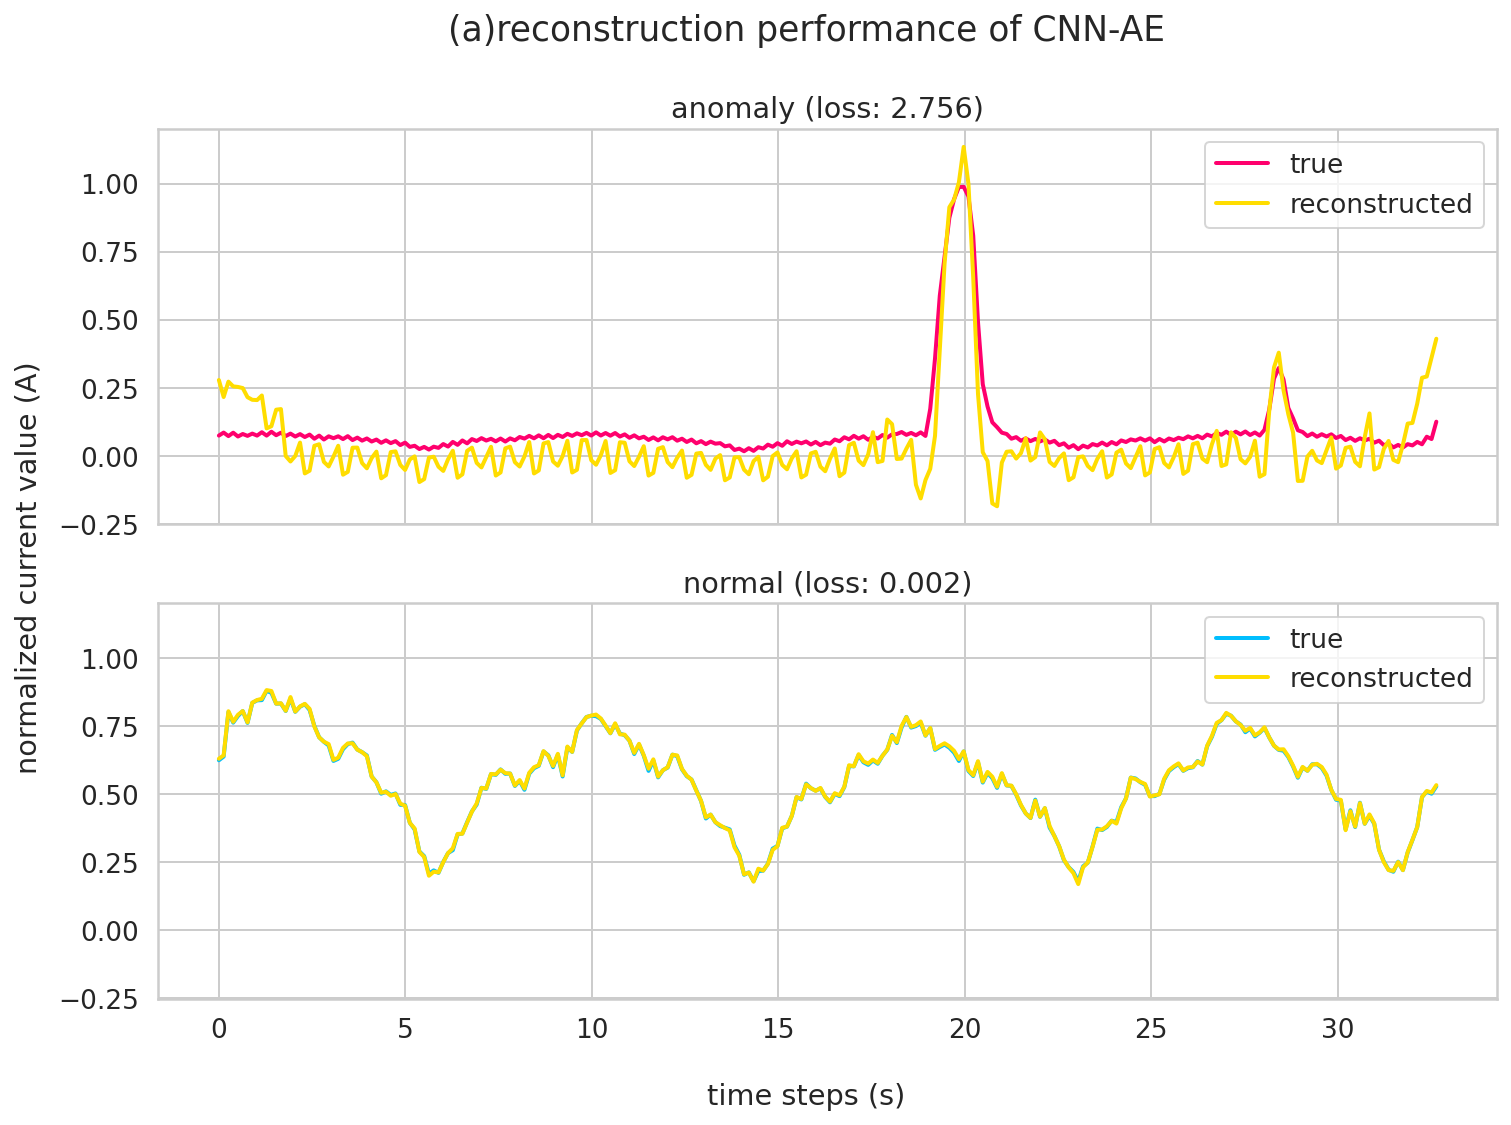

In [152]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=1,
  sharey=True,
  sharex=True,
  )

plot_prediction(testAnomalyDataloader, model, title='anomaly', ax=axs[0])
plot_prediction(testNormalDataloader, model, title='normal', ax=axs[1])


fig.suptitle('(a)reconstruction performance of CNN-AE')
# fig.suptitle('(b)reconstruction performance of TCN-AE')
# fig.suptitle('(c)reconstruction performance of LSTM-AE')
# fig.suptitle('(b)reconstruction performance of CNN-LSTM-AE')

fig.text(0.5,0.04, "time steps (s)", ha="center", va="center")
fig.text(0.05,0.5, "normalized current value (A)", ha="center", va="center", rotation=90)

In [ ]:
class Meter:
  def __init__(self, n_classes=2):
    self.targets = []
    self.predictions = []
    self.metrics = {}
    self.confusion = np.zeros((n_classes, n_classes)).astype(int)

  def init_metrics(self):
    self.metrics['accuracy'] = 0
    self.metrics['f1'] = 0
    self.metrics['precision'] = 0
    self.metrics['recall'] = 0

  def update(self, x, y):
    self._compute_cm(x, y)

    self.targets = np.hstack((self.targets, x))
    self.predictions = np.hstack((self.predictions, y)) 

  def _compute_cm(self, x, y):
    for prob, target in zip(x, y):
      self.confusion[int(target)][int(prob)] += 1
  
  def _compute_metric(self):
    self.metrics['accuracy'] += round(accuracy_score(self.targets, self.predictions),5)
    self.metrics['f1'] += round(f1_score(self.targets, self.predictions,average='macro'),5)
    self.metrics['precision'] += round(precision_score(self.targets, self.predictions, average='macro', zero_division=1),5)
    self.metrics['recall'] += round(recall_score(self.targets, self.predictions, average='macro', zero_division=1),5)
      
  def get_metrics(self):
    return self.metrics
  
  def get_accuracy(self):
    return self.metrics['accuracy']
  
  def get_f1(self):
    return self.metrics['f1']

  def get_precision(self):
    return self.metrics['precision']

  def get_recall(self):
    return self.metrics['recall']
    
  def get_confusion_matrix(self):
    return self.confusion

  def plot_confusion_matrix(self, classes=class_names, title='Confusion matrix', color_map='Blues'):
    disp = ConfusionMatrixDisplay(confusion_matrix=self.confusion, display_labels=class_names)
    disp.plot(cmap=color_map, values_format='')
    plt.grid(False)
    plt.title(title)
    plt.show()

meter = Meter()
meter.init_metrics()

In [ ]:
originals_normal, predictions_normal, pred_losses_normal = predict(model, testNormalDataloader)
originals_anomaly, predictions_anomaly, pred_losses_anomaly = predict(model, testAnomalyDataloader)

In [ ]:
num_all_sammples = len(pred_losses_anomaly) + len(pred_losses_normal)
THRESHOLD = linspace(0.0,1.0,500)
best_threshold = 0
best_accuracy = 0
for threshold in THRESHOLD:
  correct = sum(i > threshold for i in pred_losses_anomaly) + sum(i <= threshold for i in pred_losses_normal)
  correct = correct / num_all_sammples
  if correct > best_accuracy:
    best_accuracy = correct
    best_threshold = threshold

print(f'Correct threshold: {best_threshold}')
print(f'Correct predictions rate: {best_accuracy}')

Correct threshold: 0.4929859719438877
Correct predictions rate: 1.0


Text(0.5, 0, 'values')

Text(0, 0.5, 'counts')

Text(0.5, 1.0, 'reconstruction loss of normal data')

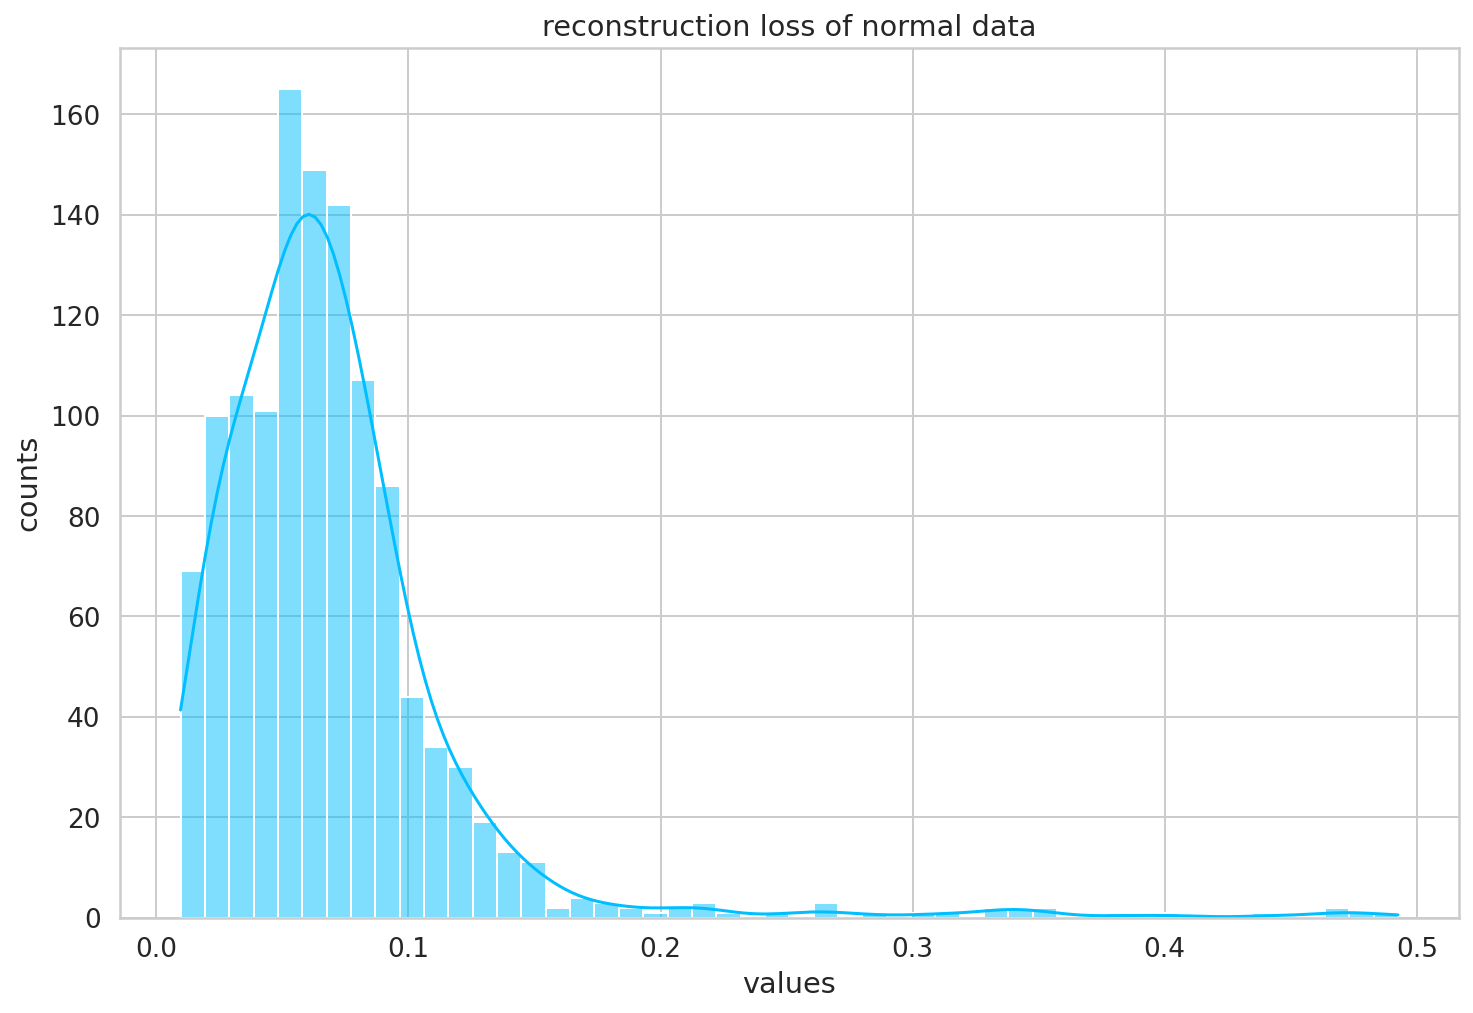

Correct normal predictions: 1212/1212
0.009610865265130997
0.49252641201019287


In [ ]:
fig = sns.histplot(pred_losses_normal, bins=50, kde=True);
plt.xlabel("values")
plt.ylabel("counts")
plt.title("reconstruction loss of normal data")
plt.show(fig)

correct = sum(l <= best_threshold for l in pred_losses_normal)
print(f'Correct normal predictions: {correct}/{len(test_normal_X)}')
print(min(pred_losses_normal))
print(max(pred_losses_normal))

target_normal = np.full_like(pred_losses_normal, CLASS_NORMAL)
pred_normal = np.full_like(pred_losses_normal, CLASS_NORMAL)
for id, i in enumerate(pred_losses_normal):
  if i > best_threshold:
    pred_normal[id] = CLASS_ANOMALY
meter.update(target_normal, pred_normal)

Text(0.5, 0, 'values')

Text(0, 0.5, 'counts')

Text(0.5, 1.0, 'reconstruction loss of anomaly data')

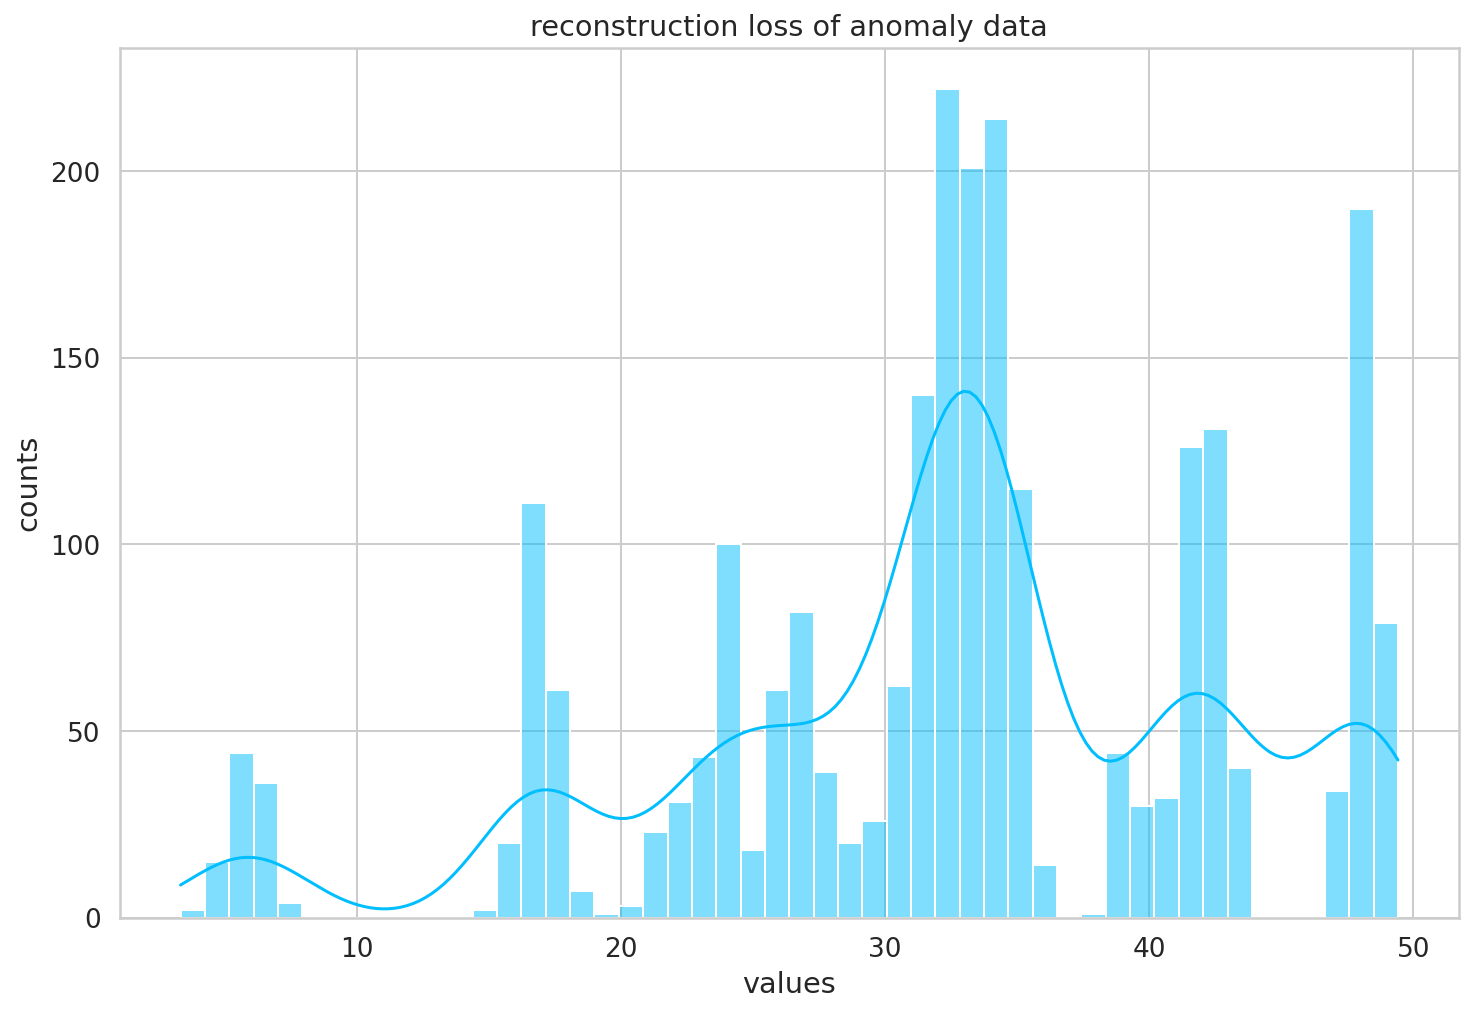

Correct left side anomaly predictions: 2424/2424
3.3300414085388184
49.41952133178711


In [ ]:
originals_anomaly, predictions_anomaly, pred_losses_anomaly = predict(model, testAnomalyDataloader)

fig = sns.histplot(pred_losses_anomaly, bins=50, kde=True);
plt.xlabel("values")
plt.ylabel("counts")
plt.title("reconstruction loss of anomaly data")
plt.show(fig)

correct = sum(l > best_threshold for l in pred_losses_anomaly)
print(f'Correct left side anomaly predictions: {correct}/{len(test_anomaly_X)}')
print(min(pred_losses_anomaly))
print(max(pred_losses_anomaly))

target_anomaly = np.full_like(pred_losses_anomaly, CLASS_ANOMALY)
pred_anomaly = np.full_like(pred_losses_anomaly, CLASS_ANOMALY)
for id, i in enumerate(pred_losses_anomaly):
  if i <= best_threshold:
    pred_anomaly[id] = CLASS_NORMAL
meter.update(target_anomaly, pred_anomaly)

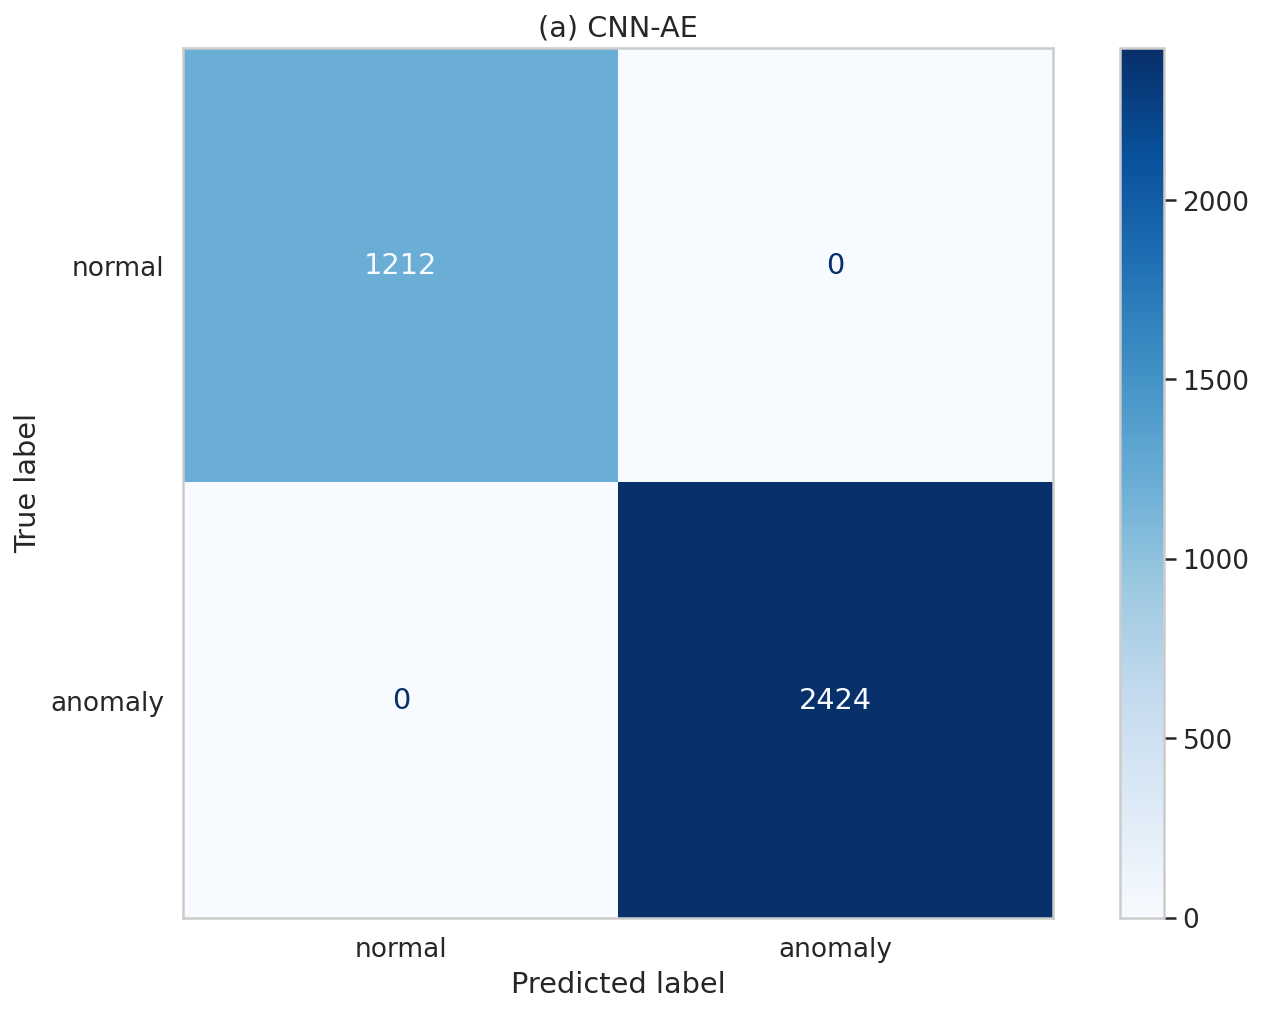

{'accuracy': 1.0, 'f1': 1.0, 'precision': 1.0, 'recall': 1.0}


In [ ]:
meter._compute_metric()

meter.plot_confusion_matrix(title='(a) CNN-AE')
# meter.plot_confusion_matrix(title='(b) TCN-AE')
# meter.plot_confusion_matrix(title='(c) LSTM-AE')
# meter.plot_confusion_matrix(title='(b) CNN-LSTM-AE')

print(meter.get_metrics())

Text(0.5, 0, 'counts')

Text(0, 0.5, 'reconstruction loss')

Text(0.5, 1.0, '(c)distribution of reconstruction loss of CNN-AE')

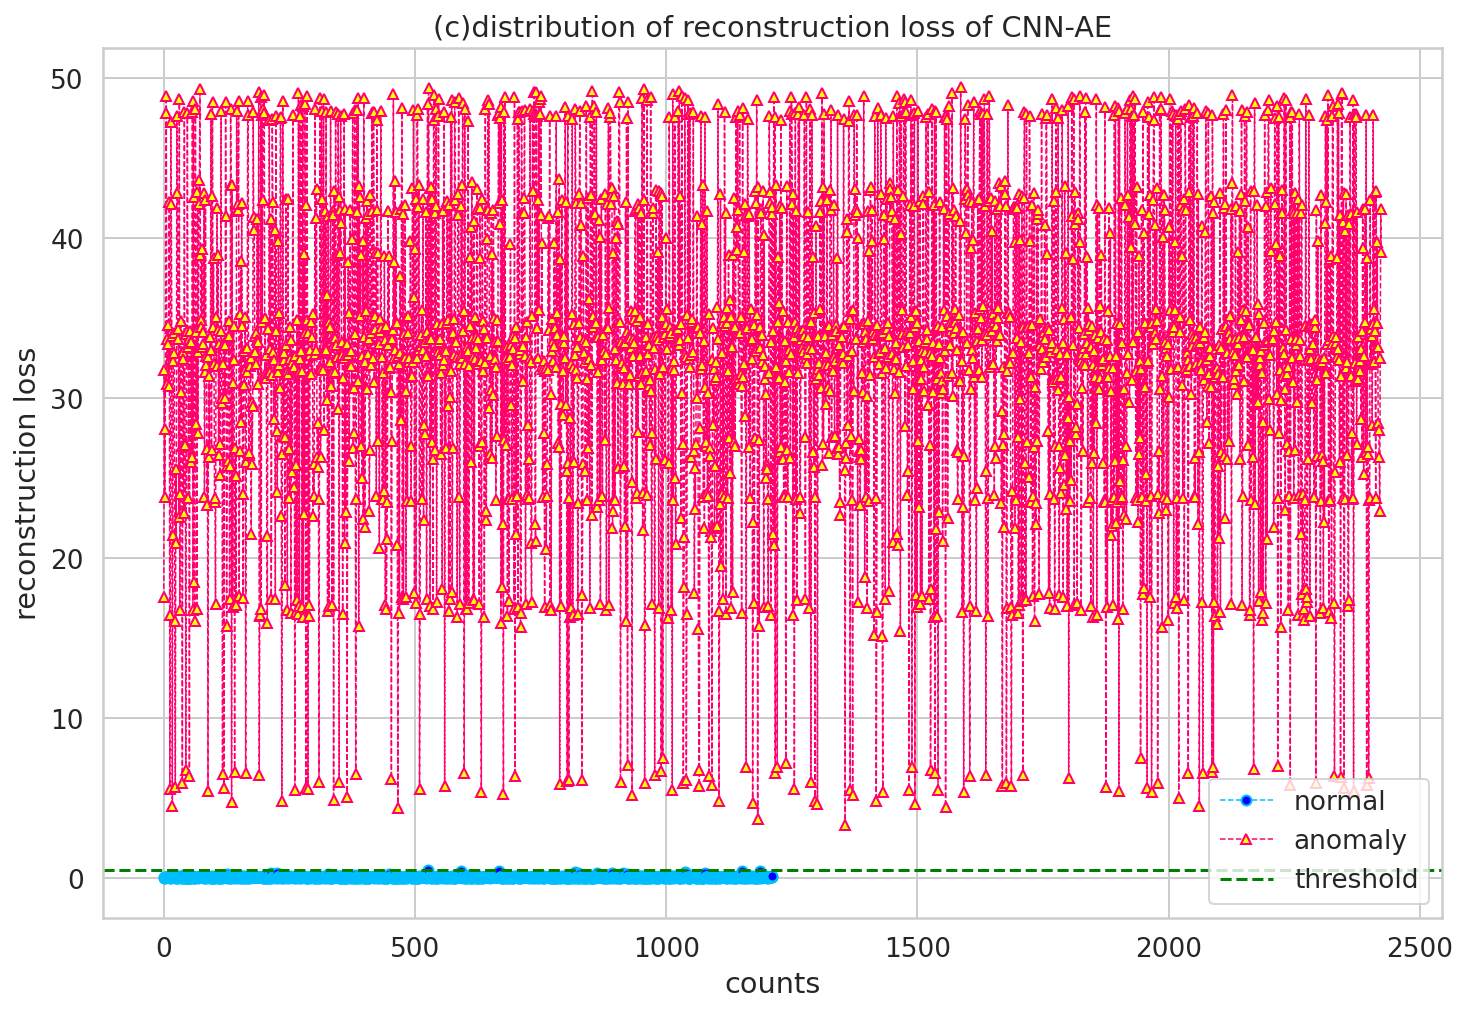

In [ ]:
plt.plot(pred_losses_normal,
    color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0],
    label='normal',
    marker='o',
    markerfacecolor='blue',
    linestyle='dashed',
    linewidth=0.75,
    markersize=5)
plt.plot(pred_losses_anomaly,
    color=plt.rcParams['axes.prop_cycle'].by_key()['color'][3],
    label='anomaly',
    marker='^',
    markerfacecolor='yellow',
    linestyle='dashed',
    linewidth=0.75,
    markersize=5)
plt.axhline(y = best_threshold, color='green', ls='--', label='threshold')


plt.xlabel('counts')
plt.ylabel('reconstruction loss')

# plt.annotate(f'best threshold: {round(best_threshold,4)}\n Correct predictions rate: {round(best_accuracy*100,2)}%', 
#   xy = (175, best_threshold), 
#   xytext = (175, -1),
#   arrowprops = {
#     'headwidth': 10, # 箭头头部的宽度
#     'headlength': 5, # 箭头头部的长度
#     'width': 2, # 箭头尾部的宽度
#     'facecolor': 'green', # 箭头的颜色
#     'shrink': 0.05, # 从箭尾到标注文本内容开始两端空隙长度
#   },
#   family='Times New Roman',  # 标注文本字体为Times New Roman
#   fontsize=12,  # 文本大小
#   fontweight='bold',  # 文本为粗体
#   color='green',  # 文本颜色
#   ha = 'center' # 水平居中
# )

plt.title(f'(c)distribution of reconstruction loss of CNN-AE')
# plt.title(f'(b)distribution of reconstruction loss of TCN-AE')
# plt.title(f'(c)distribution of reconstruction loss of LSTM-AE')
# plt.title(f'(d)distribution of reconstruction loss of CNN-LSTM-AE')

plt.legend()